# PUNTUACIONES SAT EN INSTITUTOS DE NUEVA YORK Factores que influyen en las puntuaciones

Vamos a estudiar la relación entre las puntuaciones SAT y los factores externos (raza, distrito, domicilio de los alumnos, seguridad en las aulas, etc.) que pueden influir en las puntuaciones.

**¿Qué es SAT?**

Podríamos definir el SAT como el equivalente estadounidense a la Selectividad en España.

Es un examen estandarizado que se utiliza para la admisión universitaria en Estados Unidos. 

El SAT actual, en vigor desde 2005, tiene una duración de 3h45min, y un costo de entre 47 y 52 dólares americanos (precios a fecha de 2017). 

La puntuación SAT se encuentra en un rango de 600 a 2400, combinando resultados de diferentes pruebas de tres secciones de 800 puntos cada una: Matemáticas, Lectura Crítica y Escritura.

*fuente: Wikipedia*

**Qué vamos a estudiar?**

Vamos a estudiar si existe relación entre distintos factores socio-económicos de los alumnos como lugar de residencia, capacidad económica, raza, etc. y las puntuaciones SAT, con datos oficiales obtenidos de NYC Open Data.

Para ello, utilizaremos una serie de datasets relacionados entre sí, que contienen distintos datos  demográficos, de puntuaciones, de institutos de la ciudad de Nueva York, etc.

## Comentarios preliminares

- Solo los estudiantes de institutos realizan el SAT, por lo que nos centraremos en institutos.
- NYC tiene cinco distritos, que son esencialmente cinco regiones distintas
- Las escuelas de NYC se encuentran dentro de varios distritos escolares diferentes, cada uno de los cuales puede contener docenas de escuelas.
- Nuestros datasets contienen muchos tipos distintos de escuelas. Necesitamos limpiarlos para centrarnos únicamente en institutos.
- Cada escuela en NYC tiene un código único 'DBN' (District Borough Number)
- La agregación de datos por distrito nos permite usar los datos del mapa del distrito para trazar las diferencias distrito por distrito.

## Configuración del entorno de análisis

Vamos a realizar las importaciones de los módulos que utilizaremos.

En este caso, utilizaremos Pandas y NumPy para trabajar con DataFrames, matplotlib y Seaborn para visualizar gráficos y el módulo re para utilizar expresiones regulares.

Escribiremos algunas otras líneas de código para configurar ciertos detalles que harán el notebook más atractivo visualmente y evitará ciertos warnings que pudieran darse durante el desarrollo de los análisis.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# pandas mostrará todas las columnas si lo deseamos
pd.set_option('display.max_columns', None)

# Evitamos el copyWarning de pandas
pd.options.mode.chained_assignment = None 

# Mostramos gráficos de matplotlib inline
%matplotlib inline

# Centramos los outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
}
</style>
""")

### Los datasets

Tenemos 8 datasets que están relacionados entre sí.

Cada uno de ellos contiene datos distintos sobre las distintas escuelas de Nueva York, y los iremos analizando a medida que los vayamos explorando.

Los datasets son públicos y han sido descargados de NYC Open Data

https://opendata.cityofnewyork.us/

### Lectura de los datasets

Vamos a leer los datasets.

Los nombres de los datasets (incluyendo los formatos) son los siguientes:

- **ap_2010.csv** - Datos sobre resultados en exámenes AP
- **class_size.csv**- Datos sobre el tamaño de las clases
- **demographics.csv** - Datos demográficos
- **graduation.csv** - Datos sobre los resultados de la graduación
- **hs_directory.csv** - Directorio de institutos
- **sat_results.csv** - Datos de puntuaciones SAT
- **survey_all.txt** - Datos sobre encuestas de todas las escuelas
- **survey_d75.txt** - Datos sobre encuestas del Distrito 75 de Nueva York

Por el momento, vamos a leer los seis datasets en formato csv, y más adelante leeremos los dos datasets en formato txt - *survey_all.txt y survey_d75.txt.*

In [2]:
# Estos son los nombres de nuestros datasets
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Creamos un diccionario vacío donde leeremos los datasets
data = {}

In [3]:
# Leemos cada uno de los datasets
data['ap_2010'] = pd.read_csv('ap_2010.csv')
data['class_size'] = pd.read_csv('class_size.csv')
data['demographics'] = pd.read_csv('demographics.csv')
data['graduation'] = pd.read_csv('graduation.csv')
data['hs_directory'] = pd.read_csv('hs_directory.csv')
data['sat_results'] = pd.read_csv('sat_results.csv')

### Primeras visualizaciones de los datasets

Estamos principalmente interesados en el dataset que contiene las puntuaciones SAT, que corresponde a la clave 'sat_results' del diccionario 'data'.

Este dataset contiene las puntuaciones SAT de cada instituto de Nueva York. Queremos conocer la correlación existente entre la información contenida en este dataset con la información de los demás datasets.

Vamos a realizar una primera exploración a 'sat_results' para familiarizarnos con el dataset. Esto nos ayudará a conocer su estructura y facilitará los análisis posteriores.

### Dataset *sat_results* - Resultados en exámenes SAT

In [4]:
# Mostramos las primeras filas del dataset 'sat_results'
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Echando un primer vistazo al dataset, podemos observar lo siguiente:

- La columna *DBN* es un número único asociado al instituto
- Se deduce que *SCHOOL NAME* solo contiene institutos, al tratarse de puntuaciones SAT. Recordemos que SAT es un examen previo a la universidad.
- Las tres últimas columnas son las notas medias de los tres exámenes SAT, por lo que sería bueno sumarlas y agregar una columna adicional que contenga las puntuaciones medias totales para cada instituto.

**Vamos ahora a mostrar las primeras filas de cada uno de los datasets, para poder empezar a analizar de qué manera podríamos combinarlos entre sí:**

### Dataset *ap_2010* - Resultados en exámenes AP

In [5]:
# Mostramos las primeras filas del dataset 'ap_2010'
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


### Dataset *class_size* - Tamaño de las clases

In [6]:
# Mostramos las primeras filas del dataset 'class_size'
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


### Dataset *demographics* - Datos sobre demografía

In [7]:
# Mostramos las primeras filas del dataset 'demographics'
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,38,52,29,38,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.8,57.0,20.3,25,9,10,3.6,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,34,42,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,15.6,55.0,22.6,19,15,18,7.4,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,38,47,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,19.9,60.0,23.0,20,14,16,6.1,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,34,39,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,19.0,62.0,24.6,21,17,16,6.3,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,30,24,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,19.2,46.0,22.1,14,14,16,7.7,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


### Dataset *graduation* - Datos sobre los resultados de la graduación

In [8]:
# Mostramos las primeras filas del dataset 'graduation'
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,0,0%,0%,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,0,0%,0%,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,0,0%,0%,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


### Dataset *hs_directory* - Directorio de institutos de Nueva York

In [9]:
# Mostramos las primeras filas del dataset 'hs_directory'
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,"Bx13, Bx15, Bx17, Bx21, Bx35, Bx4, Bx41, Bx4A,...","2, 5 to Intervale Ave",1110 Boston Road,Bronx,NY,10456,www.hsvd.org,378.0,Morris Educational Campus,NaN,The High School for Violin and Dance (HSVD) is...,Freshmen take both violin and dance; College N...,Spanish,NaN,NaN,NaN,Advancement via Individual Determination (AVID...,"Baseball, Basketball & JV Basketball, Volleyball","Basketball, Softball, Volleyball",NaN,Morris Educational Campus Basketball and Volle...,McGraw Hill - Big Brother Big Sister,NaN,"Hostos Community College, Monroe College, Teac...",Bronx Arts Ensemble,buildOn,Print International,NaN,Bronx Cares,Our students are required to take four years o...,"Student Summer Orientation, Summer Internship ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Bronx students or residents who at...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,"Bx1, Bx11, Bx13, Bx18, Bx2, Bx3, Bx32, Bx35, Bx36","4 to Mt Eden Ave ; B, D to 170th St",1501 Jerome Avenue,Bronx,NY,10452,http://schools.nyc.gov/schoolportals/09/X327,543.0,DOE New Settlement Community Campus,NaN,At the Comprehensive Model School Project (CMS...,"After-school and Saturday Tutoring, Advisory, ...",Spanish,"Biology, Chemistry, United States History",NaN,NaN,"Choir, Gaming, Girls Club, Newspaper, Spanish,...",NaN,NaN,NaN,"As we expand, we plan to offer PSAL sports.",New Settlement Community Center,Montefiore Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Dress Code Required: white or baby blue button...,NaN,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Bronx students or residents who attend...,Then to New York City residents who attend an ...,Then to Bronx stud

**Podemos hacer ciertas observaciones basadas en las primeras filas de cada dataset:**

- Cada dataset dispone del DBN de la escuela, o la información necesaria para construirlo. Esto quiere decir que podemos combinar los datasets en base al DBN.
- Algunos datasets contienen varias filas para una misma escuela, porque vemos el mismo DBN en varias filas distintas. Esto significa que debemos unificar dichas filas de tal manera que solo tengamos una única fila por cada DBN, para poder combinar los datasets.

### Lectura de los datasets con data sobre encuestas - *survey_all.txt , survey_d75.txt* Combinación de ambos datasets

Como comentamos antes de leer los seis datasets que teníamos en formato CSV, vamos ahora a leer los dos datasets que nos faltan.

Estos datasets están en formato TXT y tienen un formato más complejo que los demás. Están codificados en *windows-1252*. Vamos a leerlos con Pandas:

In [10]:
# Leemos los datasets 
survey_all = pd.read_csv('survey_all.txt', encoding='windows-1252', delimiter='\t')
survey_d75 = pd.read_csv('survey_d75.txt', encoding='windows-1252', delimiter='\t')

In [11]:
# Información de survey_all
survey_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Columns: 1942 entries, dbn to s_N_q14g_4
dtypes: float64(1931), int64(6), object(5)
memory usage: 24.4+ MB


In [12]:
# Información de survey_d75
survey_d75.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Columns: 1773 entries, dbn to s_q14_11
dtypes: float64(478), int64(1290), object(5)
memory usage: 775.8+ KB


Los datasets que acabamos de leer tienen, respectivamente, 1942 y 1773 columnas.

Vamos a combinarlos de una vez para unificarlos en un solo dataset.

In [13]:
# Combinamos 'survey_all' y 'survey_d75'
survey = pd.concat([survey_all, survey_d75])

In [14]:
# Mostramos la información relativa al nuevo dataset, 'survey'
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2773 entries, dbn to s_q14_11
dtypes: float64(2762), int64(6), object(5)
memory usage: 36.0+ MB


In [15]:
# Mostramos las primeras filas de 'survey'
survey.head()

dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p    N_s   N_t  \
0         0.0           Elementary School   NaN    88    60    NaN  22.0   
1         0.0           Elementary School   NaN   100    60    NaN  34.0   
2         0.0           Elementary School   NaN    88    73    NaN  42.0   
3         0.0  Elementary / Middle School  89.0    73    50  145.0  29.0   
4         0.0           Elementary School   NaN   100    60    NaN  23.0   

     N_p  nr_s  nr_t  nr_p  saf_p_11  com_p_11  eng_p_11  aca_p_11  saf_t_11  \
0   90.0     0    25   150       8.5       7.6       7.5       7.8       7.5   
1  161.0     0    33   269       8.4       7.6       7.6       7.8       8.6   
2  367.0     0    48   505       8.9       8.3       8.3       8.6       7.6   
3  151.0   163    40   301       8.8       8.2       8.0       8.5       7.0   
4   90.0     0    23   151       8.7       7.9       8.1       7.9       8.4   

   com_t_11  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0       7.8       7.6       7.9       NaN       NaN       NaN       NaN   
1       8.5       8.9       9.1       NaN       NaN       NaN       NaN   
2       6.3       6.8       7.5       NaN       NaN       NaN       NaN   
3       6.2       6.8       7.8       6.2       5.9       6.5       7.4   
4       7.3       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  p_q2h  p_q7a  p_q7b  p_q7c  \
0         8.0         7.7         7.5         7.9    8.0    8.2    8.3    7.5   
1         8.5         8.1         8.2         8.4    7.7    7.9    8.0    7.3   
2         8.2         7.3         7.5         8.0    8.1    8.8    8.9    8.5   
3         7.3         6.7         7.1         7.9    8.1    8.5    8.8    8.2   
4         8.5         7.6         7.9         8.0    8.0    8.4    8.6    8.0   

   p_q7d  p_q8a  p_q8b  p_q8c  p_q8d  p_q8e  p_q8f  p_q2b  p_q2d  p_q2e  \
0    7.9    6.8    8.7    9.7    8.7    9.9    9.9    7.7    8.3    7.9   
1    7.7    6.5    8.8    9.4    8.7   10.0    9.9    7.5    8.2    7.9   
2    8.4    7.6    9.2    9.4    9.2    9.8    9.7    8.4    8.8    8.5   
3    8.3    7.3    9.2    9.4    9.1    9.8    9.7    8.3    8.7    8.3   
4    8.0    6.5    8.8    9.6    9.4   10.0   10.0    7.6    8.5    8.0   

   p_q2f  p_q2g  p_q3a  p_q3b  p_q4b  p_q4c  p_q11c  p_q2a  p_q2c  p_q3c  \
0    8.1    7.5    7.3    6.7    7.6    7.9     7.5    8.0    7.4    8.7   
1    8.0    7.2    7.0    6.9    8.0    8.4     7.4    7.6    7.1    9.0   
2    8.3    8.0    7.6    7.3    8.6    8.7     8.4    8.8    8.2    8.8   
3    8.1    7.6    7.6    7.5    8.6    8.6     8.4    8.5    8.1    8.8   
4    8.2    7.4    7.8    7.2    8.1    7.9     7.8    8.2    8.3    9.2   

   p_q6a  p_q6b  p_q11d  p_q11e  p_q5  p_q4a  p_q4d  p_q4e  p_q11a  p_q11b  \
0    6.3    6.6     7.6     7.6   7.4    7.8    7.4    NaN     8.3     7.5   
1    6.4    6.5     7.6     7.8   8.6    7.7    7.8    NaN     8.3     7.6   
2    7.9    6.8     8.5     8.5   8.7    8.6    8.5    NaN     8.9     8.4   
3    7.3    6.8     8.2     8.3   8.0    8.7    8.3    NaN     8.8     8.3   
4    7.4    7.0     7.9     7.9   8.8    8.2    7.8    NaN     8.1     7.6   

   p_q11f  p_q1  p_q3d  p_q9  p_q10  p_q12aa  p_q12ab  p_q12ac  p_q12ad  \
0     7.7   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
1     7.7   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
2     8.6   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
3     8.5   Na

El dataset que acabamos crear, *survey*, tiene 1702 filas y 2773 columnas.

Los datasets que hemos descargado tienen archivos de documentación que podemos consultar, que contiene información relativa al dataset. 

En el siguiente enlace podemos descargar el diccionario de documentación de los datasets que acabamos de combinar:

https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8

De la documentación concluimos que las columnas que nos interesan son las siguientes:

In [16]:
# Creamos una lista con las columnas que nos interesan, para saber cuáles podemos descartar
columnas = ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", 
            "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
            "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", 
            "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", 
            "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

Estas columnas nos ofrecen data agregada sobre como los padres, profesores y estudiantes perciben aspectos de las escuelas como la seguridad, el rendimiento académico, y más. También nos ofrece el DBN, que nos permite identificar cada escuela.

Lo primero que vamos a hacer es renombrar la columna 'dbn' como 'DBN', por uniformidad con los demás datasets.

In [17]:
# Renombramos la columna 'dbn' como 'DBN'
survey['DBN'] = survey['dbn']

A continuación, vamos a filtrar por las columnas que nos interesan, y construiremos un nuevo DataFrame con las mismas; hay que renombrar la columna 'dbn' de la variable *columnas* como 'DBN' (la que acabamos de crear).

In [18]:
# nueva variable columnas
columnas = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", 
            "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
            "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", 
            "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", 
            "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

In [19]:
# Añadimos el nuevo DataFrame al diccionario 'data', que contiene los demás datasets
data['survey'] = survey[columnas]

In [20]:
# Comprobamos que el DataFrame se ha agregado al diccionario
data['survey']

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,7.8,7.5,7.8,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,7.8,8.6,8.5,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,8.6,7.6,6.3,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,8.5,7.0,6.2,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,7.9,8.4,7.3,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,75X352,90.0,58,48,38.0,46.0,160.0,8.9,8.3,7.9,8.2,6.4,5.5,5.7,5.8,6.8,6.0,7.8,7.6,7.4,6.6,7.1,7.2
52,75X721,84.0,90,48,237.0,82.0,239.0,8.6,7.6,7.5,7.7,7.6,6.4,6.7,7.0,7.8,7.2,7.8,7.9,8.0,7.1,7.3,7.6
53,75X723,77.0,74,20,103.0,69.0,74.0,8.4,7.8,7.8,7.8,7.7,7.2,6.7,7.6,6.7,7.2,7.7,7.7,7.6,7.4,7.4,7.7
54,75X754,63.0,93,22,336.0,82.0,124.0,8.3,7.5,7.5,7.8,6.7,6.5,6.6,7.1,6.8,6.6,7.6,7.7,7.2,6.9,7.3,7.5


### Estandarización de las columnas *DBN*

Nuestra idea es unificar todos los datasets en uno solo, de tal manera que podamos trabajar sobre un único DataFrame. 

Como la manera más viable de combinarlos es mediante la columna *DBN*, debemos tener la columna de la misma manera en todos los DataFrames.

Ya hemos mostrado las columnas de todos ellos, y hay dos expepciones que debemos modificar:

- **En el dataset 'class_size' no existe la columna *DBN*. Existen una serie de columnas que combinadas dan como resultado el DBN, y por tanto debemos combinarlas.**
- **En el dataset 'hs_directory' la columna *dbn* está en minúsculas, por lo que simplemente debemos renombrarla (al igual que acabamos de hacer con el dataset 'survey').**

Vamos a mostrar la primera fila de cada uno de los datasets para comprobarlo:

In [21]:
# Primera fila del DataFrame 'class_size'
data['class_size'].head(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


In [22]:
# Primera fila del DataFrame 'hs_directory'
data['hs_directory'].head(1)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."


De momento vamos a renombrar la columna *dbn* del DataFrame 'hs_directory', y después veremos qué técnica utilizamos para crearla en el DataFrame *class_size*:

In [23]:
# Renombramos la columna 'dbn' en 'hs_directory'
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

**Ahora debemos crear la columna en el DataFrame *class_size*.**

Vamos a ver en detalle cual es la estructura de los elementos que componen el DBN en el DataFrame:



In [24]:
# Primera fila del DataFrame 'class_size'
data['class_size'].head(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


In [25]:
# Última fila del DataFrame 'class_size'
data['class_size'].tail(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
27610,32,K,K564,Bushwick Community High School,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.1


Atendiendo a la estructura de los DBN en los demás DataFrames:

- Empieza siempre por dos números
- Sigue con una letra
- Acaba con tres números
- **La estructura es 11A111**

Si observamos el DataFrame 'class_size', vemos:

- La columna 'CSD' son los dos primeros números, pero si el número es menor que 10, entonces solo aparece un número. Por ejemplo, el DBN del instituto Roberto Clemente es 01M015, pero en la columna 'CSD' solo aparece un 1. Por tanto, a todos los números menores que 10 en la columna 'CSD', debemos añadirle un 0 al principio (1 se convierte en 01).
- La columna 'BOROUGH' es la letra del DBN, pero podemos descartarla porque la columna 'SCHOOL CODE' ya contiene tanto la letra como los tres últimos números del DBN. Resumiendo:
    - **Extraemos los valores de la columna 'CSD'. Si el valor es menor que 10, agregamos un 0 al principio.**
    - **Concatenamos los valores de la columna 'CSD' con los valores de la columna 'SCHOOL CODE', y obtenemos el DBN.**
    - **Agregamos el valor recién concatenado (el DBN) a una nueva columna llamada 'DBN'**
    
Siguiendo la lógica que acabamos de explicar, vamos a construir la columna:

In [26]:
# Construcción de la columna 'DBN' en el DataFrame 'class_size'

def modif_csd(valor):
    '''
    Recibe la columna "CSD" del DataFrame 
    "class_size", y agrega un cero al principio 
    en caso de que el valor sea menor que 10
    '''
    return str(valor).zfill(2)

# creamos una nueva columna con los valores modificados de la columna 'CSD'
data['class_size']['CSD_MOD'] = data['class_size']['CSD'].apply(modif_csd)

# creamos la columna 'DBN'
data['class_size']['DBN'] = data['class_size']['CSD_MOD'] + data['class_size']['SCHOOL CODE']

In [27]:
# Comprobamos que la columna se ha creado correctamente
data['class_size']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

### Medias totales de puntuaciones SAT en el DataFrame *sat_results*

Cuando echamos el primer vistazo al DataFrame *sat_results*, vimos que se muestran las medias de las puntuaciones de los tres exámenes que componen el SAT. 

Vamos a verlo de nuevo:

In [28]:
data['sat_results'].head(1)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363


Como queremos la media global para poder trabajar con ella, vamos a crear una nueva columna que contenga la media total; para ello debemos sumar las tres columnas que contienen las notas de los tres exámenes. Utilizaremos el método *pandas.to_numeric()*, con el argumento *errors='coerce'*, que convierte los strings no-válidos a valores nulos:

In [29]:
# Creamos la nueva columna 'sat_score'
data['sat_results']['sat_score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'], errors='coerce') +\
                                   pd.to_numeric(data['sat_results']['SAT Math Avg. Score'], errors='coerce') +\
                                   pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'], errors='coerce')

In [30]:
# Comprobación de la nueva columna
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1207.0


### Extracción de las coordenadas de los institutos

El dataset *hs_directory* contiene información relativa a los institutos de Nueva York. Concretamente, tenemos las coordenadas de cada uno de los institutos en la columna 'Location 1':

In [31]:
# Columna 'Location 1'
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

Además de la latitud y la longitud, la columna contiene información que no necesitamos.

Si extraemos únicamente la latitud y la longitud, podemos localizar cualquier punto en la Tierra.

Vamos a extraerlas (para ello utilizaremos el módulo re) y descartaremos el resto de la información.

#### Extracción de la latitud

In [32]:
# Escribimos una función que extraiga la latitud
def find_lat(loc):
    '''
    Recibe un string que contiene 
    coordenadas terrestres. Devuelve 
    la latitud
    '''
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace('(','')
    return lat

# Aplicamos la función sobre la columna 'Location 1', y creamos la nueva columna 'lat'
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)  

In [33]:
# Comprobamos que la columna se ha creado correctamente
data['hs_directory']['lat'].head()

0     40.67029890700047
1      40.8276026690005
2    40.842414068000494
3     40.71067947100045
4    40.718810094000446
Name: lat, dtype: object

#### Extracción de la longitud

In [34]:
# Escribimos una función que extraiga las coordenadas
def find_lon(loc):
    '''
    Recibe un string que contiene 
    coordenadas terrestres. Devuelve 
    la longitud
    '''
    coords = re.findall("\(.+\)", loc)
    lon = coords[-1].split(",")[-1].replace(')','')
    return lon

# Aplicamos la función sobre la columna 'Location 1', y creamos la nueva columna 'lon'
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)  

In [35]:
# Verificamos la nueva columna
data['hs_directory']['lon'].head()

0     -73.96164787599963
1     -73.90447525699966
2     -73.91616158599965
3     -74.00080702099967
4     -73.80650045499965
Name: lon, dtype: object

#### Conversión de las coordenadas a valores numéricos

In [36]:
# Convertimos los valores a numéricos
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')

## Unificación por DBN

Varios datasets contienen múltiples filas para una sola escuela. Esto ocurre porque hay ciertas escuelas que ofrecen tipos distintos de educación (primaria, secundaria, etc.)y el nombre de la escuela es el mismo. Cada fila contiene información relativa al tipo de escuela de esa misma entidad.


### Unificación por DBN - dataset *class_size*

Veamos las primeras filas del dataset *class_size*:

In [37]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,CSD_MOD,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


En este ejemplo vemos como las cinco filas pertenecen a la misma escuela (Roberto Clemente), pero los valores son distintos en ciertas columnas.

En los datasets en los que ocurra esto, debemos solamente seleccionar las filas representativas de institutos (High School), que son las que nos interesan para llevar a cabo los análisis.

Aislando los institutos de esta manera, deberían quedarnos filas con DBN únicos, y podremos combinar los datasets en base a los DBN.

#### Grade Levels

Veamos los valores únicos de la columna 'GRADE' (indican los *grade levels*):

In [38]:
# Valores únicos de la columna 'GRADE' del dataset 'class_size'
data['class_size']['GRADE'] = data['class_size']['GRADE '] # Renombramos por comodidad
data['class_size']['GRADE'].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Los *grade levels* en EEUU pertenecientes a los institutos son '09-12' (se encuentra fácilmente buscando por internet). Por lo que podemos descartar las filas que tengan valores distintos de '09-12' en la columna 'GRADE'.

In [39]:
# Extraemos únicamente las filas correspondientes a los High Schools
class_size = data['class_size'][data['class_size']['GRADE'] == '09-12']

In [40]:
data['class_size'] = class_size

In [41]:
# Comprobamos que hemos filtrado correctamente
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,CSD_MOD,DBN,GRADE
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292,09-12
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292,09-12
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292,09-12
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292,09-12
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292,09-12


#### Tipos de programas

Cada escuela tiene múltiples tipos de programas. La categoría más alta es 'GEN ED', por lo que seleccionaremos únicamente las filas cuyo valor en la columna 'PROGRAM TYPE' sean 'GEN ED'.

In [42]:
# Seleccionamos únicamente las filas cuyo valor en 'PROGRAM_TYPE' sea 'GEN ED'
data['class_size'] = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

In [43]:
# Comprobamos el nuevo DataFrame
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,CSD_MOD,DBN,GRADE
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292,09-12
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292,09-12
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292,09-12
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292,09-12
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292,09-12


Aunque hemos eliminado muchas filas que no necesitábamos, seguimos teniendo varias filas que contienen el mismo DBN, pero que no queremos perder.

Esto se debe a que en el dataset viene detallada cada clase que ofrece cada instituto, pero estos datos sí queremos mantenerlos. No tendría sentido eliminar filas arbitrariamente para quedarnos con una sola.

Vamos a agrupar todas las filas del DataFrame según su DBN y calcularemos las medias de cada columna. El DataFrame resultante contendrá DBNs únicos con las medias de las columnas.

In [44]:
# Agrupamos los valores según el DBN y calculamos las medias
class_size = data['class_size'].groupby('DBN').agg(np.mean)
# Reseteamos los índices del DataFrame
class_size.reset_index(inplace=True)
# Reescribimos el DataFrame original
data['class_size'] = class_size

In [45]:
# Mostramos el aspecto del DataFrame resultante
data['class_size']

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.000000,4.000000,22.564286,18.500000,26.571429,NaN
1,01M332,1,46.000000,2.000000,22.000000,21.000000,23.500000,NaN
2,01M378,1,33.000000,1.000000,33.000000,33.000000,33.000000,NaN
3,01M448,1,105.687500,4.750000,22.231250,18.250000,27.062500,NaN
4,01M450,1,57.600000,2.733333,21.200000,19.400000,22.866667,NaN
...,...,...,...,...,...,...,...,...
578,32K549,32,71.066667,3.266667,22.760000,19.866667,25.866667,NaN
579,32K552,32,102.375000,4.312500,23.900000,19.937500,28.000000,NaN
580,32K554,32,66.937500,3.812500,17.793750,14.750000,21.625000,NaN
581,32K556,32,132.333333,5.400000,25.060000,18.333333,30.000000,NaN


### Unificación por DBN - dataset *demographics*

Mostramos el aspecto del DataFrame:

In [46]:
# Primeras filas del DataFrame 'demographics'
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,38,52,29,38,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.8,57.0,20.3,25,9,10,3.6,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,34,42,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,15.6,55.0,22.6,19,15,18,7.4,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,38,47,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,19.9,60.0,23.0,20,14,16,6.1,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,34,39,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,19.0,62.0,24.6,21,17,16,6.3,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,30,24,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,19.2,46.0,22.1,14,14,16,7.7,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


Se ve de manera clara que cada fila representa un curso escolar (columna *schoolyear*). 

En este caso, podemos ver que hay siete cursos escolares distintos para el instituto Roberto Clemente, y ocurre de la misma manera con todos los demás. En nuestro caso, nos quedaremos con el último disponible, que es 2011/2012.

Si extraemos únicamente las filas correspondientes al curso 2011/2012 tendremos un DataFrame donde cada DBN será una única fila.

In [47]:
# Creamos un DataFrame que contenga únicamente el curso 2011/2012
demographics = data['demographics'][data['demographics']['schoolyear'] == 20112012]

In [48]:
# Reescribimos el DataFrame original y lo mostramos para comprobar que es correcto
data['demographics'] = demographics
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,25,28,29,,,,,,,,20.0,10.6,40.0,21.2,23,7,12,6.3,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,52,46,46,,,,,,,,33.0,10.1,59.0,18.0,16,16,51,15.5,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,88,85,91,,,,,,,,128.0,20.4,97.0,15.5,49,31,190,30.4,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,45,28,40,55,55,56,,,,,34.0,8.5,106.0,26.4,59,16,22,5.5,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,31,26,30,,,,,,,,6.0,3.4,45.0,25.6,34,4,9,5.1,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Unificación por DBN - dataset *graduation*

Veamos el aspecto del DataFrame:

In [49]:
# Mostramos las primeras filas del DataFrame 'graduation'
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,0,0%,0%,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,0,0%,0%,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,0,0%,0%,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


Las columnas que impiden que el DBN sea único por fila son *Demographic* y *Cohort*.

Echemos un vistazo a los valores de estas dos columnas:

In [50]:
# Valores únicos de la columna 'Demographic'
data['graduation']['Demographic'].value_counts()

Total Cohort                   2493
General Education Students     2471
English Proficient Students    2471
Special Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: Demographic, dtype: int64

In [51]:
# Valores únicos de la columna 'Cohort'
data['graduation']['Cohort'].value_counts()

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64

En base a los datos que acabamos de mostrar, haremos lo siguiente:

- En el caso de la columna *Demographic*, solo nos interesan los valores de los grupos completos. Estos valores son los correspondientes a 'Total Cohort', por lo que solamente seleccionaremos aquellas filas cuyo valor en la columna sea 'Total Cohort'.

- Respecto a la columna *Cohort*, nos interesan los datos más recientes, por lo que solo seleccionaremos los correspondientes a 2006.

In [52]:
# Filtramos en el DataFrame conforme a los criterios que hemos establecido
graduation = data['graduation'][(data['graduation']['Demographic'] == 'Total Cohort') &\
                                (data['graduation']['Cohort'] == '2006')]

In [53]:
# Reescribimos el DataFrame original y mostramos el resultado
data['graduation'] = graduation
graduation.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,8,6.5%,15.1%,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,0,0%,0%,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,17,20.2%,36.200000000000003%,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,69,35.799999999999997%,65.7%,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


Con estas últimas modificaciones ya tenemos todos los datasets de tal manera que cada fila contiene un único DBN.

Antes de combinarlos definitivamente, debemos realizar unas últimas operaciones adicionales.

### Conversión de las puntuaciones AP a valores numéricos

Las puntuaciones AP (Advanced Placement) varían en una escala de 1 a 5. Una puntuación de 3 o más es un aprobado. Muchos estudiantes se enfrentan a este examen, sobre todo aquellos que cursan sus estudios en instituciones académicamente exigentes. Los exámenes AP son mucho más raros en las escuelas que carecen de fondos o rigor académico.

Sería interesante buscar la correlación existente entre las puntuaciones AP y las puntuaciones SAT en los distintos institutos. Para analizar esto, debemos convertir las puntuaciones AP a valores numéricos para poder operar con ellos.

El dataset que contiene las puntuaciones AP es 'ap_2010'.

Vamos a ver las primeras columnas:

In [54]:
# Primeras columnas del DataFrame 'ap_2010'
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


Los tipos de datos en estas columnas no son numéricos, son de tipo string:

In [55]:
# Corroboramos que los tipos de datos no son numéricos
data['ap_2010'].dtypes

DBN                                     object
SchoolName                              object
AP Test Takers                          object
Total Exams Taken                       object
Number of Exams with scores 3 4 or 5    object
dtype: object

Las tres columnas que debemos convertir son:

- AP Test Takers
- Total Exams Taken
- Number of Exams with scores 3 4 or 5

In [56]:
# Convertimos los valores de las tres columnas a valores numéricos
data['ap_2010']['AP Test Takers'] = data['ap_2010']['AP Test Takers ']
data['ap_2010']['AP Test Takers'] = pd.to_numeric(data['ap_2010']['AP Test Takers'], errors='coerce')
data['ap_2010']['Total Exams Taken'] = pd.to_numeric(data['ap_2010']['Total Exams Taken'], errors='coerce')
data['ap_2010']['Number of Exams with scores 3 4 or 5'] = pd.to_numeric(data['ap_2010']['Number of Exams with scores 3 4 or 5'], errors='coerce')

In [57]:
# Mostramos los tipos de datos de las columnas para verificar que se han modificado correctamente
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                           object
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
AP Test Takers                          float64
dtype: object

## Combinación de datasets

Todas las operaciones que hemos realizado hasta el momento tenían como objetivo construir datasets individuales que pudiesen ser combinados (fusionados) entre sí, de tal manera que pudiésemos analizar un único dataset, minimizando al máximo la pérdida de datos.

Cuando manejamos múltiples datasets la pérdida de datos es prácticamente inevitable, sin embargo, trataremos de mantener los datos que más nos interesen para realizar nuestros análisis durante las combinaciones de los datasets.

Pandas ofrece varias maneras distintas para combinar datasets. Antes de nada, vamos a definir la estrategia que llevaremos a cabo para realizar las combinaciones.

### Estrategia de combinación de datasets

Lo que nos interesa es estudiar la correlación existente entre las puntuaciones SAT y los factores socio-económicos de los diferentes alumnos, para conocer el impacto que estos factores pudieran tener sobre las puntuaciones (y eventualmente sobre el futuro académico y profesional) de los estudiantes.

Por tanto, parece claro que el dataset *sat_results* contiene datos muy importantes para nosotros, que no nos interesa perder, o que de hacerlo, la pérdida sea la mínima posible.

Hay que tener en cuenta que tenemos que combinar ocho datasets en uno solo, y debemos hacerlo de una manera cuidadosa. Las opciones que tenemos disponibles para realizar las combinaciones son las siguientes:

- La función pd.concat() 
- La función pd.merge()

La función pd.concat() la descartamos inmediatamente porque la combinación es una concatenación de DataFrames: simplemente agrega las filas y las columnas de los datasets en uno solo (es una suma de filas y columnas).

Utilizaremos la función pd.merge(), que combina dos datasets en uno solo. Esto significa que debemos hacer varias combinaciones entre datasets para obtener el dataset definitivo que queremos obtener.

La función pd.merge() recibe dos datasets que serán combinados entre sí, y podemos elegir el tipo de combinación que queremos realizar. Tenemos cuatro opciones disponibles:

- **Inner**: solo incluye elementos que aparecen en ambos DataFrames con una clave común
- **Outer**: incluye todos los datos de ambos DataFrames
- **Left**: incluye todas las filas del DataFrame "left" junto con cualquier fila del marco de datos "right" **con una clave común (descarta las claves del "right" que no estén en el "left")**; el resultado conserva todas las columnas de los dos DataFrames originales
- **Right**: incluye todas las filas del marco de datos "right" junto con cualquier fila del marco de datos "left" **con una clave común (descarta las claves del "left" que no estén en el "right")**; el resultado conserva todas las columnas de los dos DataFrames originales

Dependiendo de los datasets que vayamos a combinar elegiremos una forma u otra, siempre tratando de minimizar al máximo la pérdida de datos durante la combinación.

### Combinaciones tipo 'left' - *sat_results*, *ap_2010* y *graduation*

Como acabamos de comentar, uno de los datasets clave es *sat_results*, y vamos a "introducir" los primeros datasets en él.

Vamos a introducir en *sat_results* los datasets *ap_2010* y *graduation* con un merge de tipo left, donde left será *sat_results*; los combinaremos en base al DBN. Esto evitará la pérdida de datos en *sat_results*.

In [58]:
# Primero asignamos 'sat_results' a una variable
combined = data['sat_results']

In [59]:
# Combinamos 'sat_results' con 'ap_2010'
combined = pd.merge(left=combined, right=data['ap_2010'], on='DBN', how='left')

In [60]:
# Combinamos el DataFrame resultante con 'graduation'
combined = pd.merge(left=combined, right=data['graduation'], on='DBN', how='left')

In [61]:
# Mostramos el aspecto del DataFrame resultante
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122.0,NaN,NaN,NaN,NaN,NaN,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39,49.0,10.0,39.0,Total Cohort,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124.0,53,42.7%,42,33.9%,79.2%,8,6.5%,15.1%,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1149.0,EAST SIDE COMMUNITY HS,19,21.0,NaN,19.0,Total Cohort,EAST SIDE COMMUNITY SCHOOL,2006,90.0,70,77.8%,67,74.400000000000006%,95.7%,0,0%,0%,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1207.0,NaN,NaN,NaN,NaN,NaN,Total Cohort,MARTA VALLE HIGH SCHOOL,2006,84.0,47,56%,40,47.6%,85.1%,17,20.2%,36.200000000000003%,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


In [62]:
# Mostramos el número de filas y columnas del DataFrame 'combined'
combined.shape

(479, 34)

### Combinaciones tipo 'inner' 

Esta vez, en lugar de realizar combinaciones tipo left, vamos a realizar combinaciones tipo inner, ya que no queremos perder tantos datos en los DataFrames que quedan por combinar.

Los datasets *class_size*, *demographics*, *survey* y *hs_directory* contienen información valiosa para nuestros análisis, y tienen menos valores perdidos de DBNs, por lo que concluimos que una combinación de tipo inner puede ser apropiada.

In [63]:
# Combinación con 'class_size'
combined = pd.merge(combined, data['class_size'], on='DBN', how='inner')

In [64]:
# Combinación con 'demographics'
combined = pd.merge(combined, data['demographics'], on='DBN', how='inner')

In [65]:
# Combinación con 'survey'
combined = pd.merge(combined, data['survey'], on='DBN', how='inner')

In [66]:
# Combinación con 'hs_directory'
combined = pd.merge(combined, data['hs_directory'], on='DBN', how='inner')

In [67]:
# Mostramos el aspecto del DataFrame resultante
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122.0,NaN,NaN,NaN,NaN,NaN,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,NaN,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,NaN,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.0,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,NaN,NaN,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,NaN,NaN,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,NaN,NaN,United Nations,NaN,NaN,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NE

In [68]:
# Comprobación del número de filas y columnas de 'combined'
combined.shape

(363, 160)

### Tratamiento de valores nulos en el DataFrame 'combined'

El DataFrame que acabamos de crear es la combinación de ocho DataFrames. Algunos de ellos ya tenían valores nulos, y otros valores nulos se crearon en el proceso de combinación de los DataFrames.

Lo que vamos a hacer es intentar minimizar los valores nulos en *combined*, de tal manera que "rellenaremos" dichos valores nulos con las medias numéricas de las columnas. Una vez realizado este paso, reemplazaremos los valores nulos restantes con ceros. Hay que recordar que queremos estudiar correlaciones, y necesitamos evitar los valores nulos.

In [69]:
# Calculamos las medias de las columnas
combined_means = combined.mean()

In [70]:
# Reemplazamos los valores nulos con las medias
combined = combined.fillna(combined_means)

In [71]:
# Reemplazamos los valores nulos restantes con ceros
combined = combined.fillna(0)

In [72]:
# Mostramos el aspecto del DataFrame
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122.0,0,0,197.038462,153.45,129.028846,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0.0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1

### Columna con los distritos de los institutos

Uno de los factores que pueden influir en las puntuaciones de los alumnos puede ser el Distrito Escolar. Este Distrito viene representado en el DBN (los dos primeros números de los DBN hacen referencia al Distrito Escolar). 

Vamos a crear una columna en el DataFrame que contenga el Distrito Escolar de cada instituto para poder utilizarlo en análisis futuros.

In [73]:
# Creamos una función que extraiga el Distrito Escolar del DBN
def distrito_escolar(dbn):
    '''
    Recibe los DBN en formato 
    11A111, y extrae los dos 
    primeros números
    '''
    distrito = dbn[0:2]
    return distrito

# Creamos la nueva columna, aplicando la función a la columna 'DBN'
combined['school_dist'] = combined['DBN'].apply(distrito_escolar)

In [74]:
# Comprobamos los valores únicos de la columna que hemos creado
combined.school_dist.value_counts()

02    48
10    22
09    20
11    15
17    14
14    14
24    13
07    13
13    13
03    12
12    12
19    12
18    11
21    11
08    11
28    11
31    10
27    10
06    10
15     9
30     9
29     8
25     8
04     7
05     7
32     6
01     6
20     5
26     5
22     4
16     4
23     3
Name: school_dist, dtype: int64

## Correlación entre valores - Coeficiente de correlación de Pearson

Vamos a empezar a buscar correlaciones entre columnas en el DataFrame que hemos construido.

La correlación nos indica cómo de relacionados están dos valores entre sí.

Vamos a utilizar el **valor r o Coeficiente de Correlación de Pearson**, que indica cuan relacionados están entre sí dos secuencias numéricas.

El valor r varía en una escala de -1 a 1, donde -1 sería una correlación negativa perfecta, en 0 no existiría correlación alguna, y 1 una correlación positiva perfecta.

En general, valores menores a -0.25 o mayores a 0.25 son suficientes para calificar una correlación como interesante. Un valor r no es un indicador perfecto, y no indica de manera firme que existe una correlación, solo que posiblemente existe.

Vamos a echar un vistazo a las correlaciones existentes con las puntuaciones SAT:

In [75]:
# Correlación entre valores del DataFrame
correlations = combined.corr()
correlations

,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
sat_score,1.000000,0.514333,0.463245,0.523140,0.325144,0.042948,0.394626,0.362673,0.381014,0.249949,0.314434,NaN,NaN,NaN,-0.722225,0.367857,-0.153778,-0.398750,0.034933,-0.448170,0.475445,0.570730,0.027979,-0.284139,0.025744,-0.396985,0.449559,0.620718,0.325520,-0.112062,0.388631,0.112108,0.232199,-0.023386,0.047925,0.423463,0.291463,0.421530,0.122913,-0.115073,0.020254,0.035155,0.313810,0.082419,0.036906,0.132348,0.337639,0.187370,0.213822,0.339435,0.318753,0.077310,0.100102,0.190966,NaN,NaN,-0.063977,0.407827,0.117012,NaN,NaN,NaN,-0.121029,-0.132222
Total Exams Taken,0.514333,1.000000,0.930634,0.992192,0.558005,0.073661,0.662042,0.629946,0.307422,0.165481,0.231253,NaN,NaN,NaN,-0.321325,0.611283,0.107767,-0.075268,0.177760,-0.242938,0.798364,0.472686,0.132201,-0.212726,0.184608,-0.217161,0.517573,0.288372,0.600467,0.032804,0.580293,-0.032795,0.069768,-0.016841,0.000027,0.661808,0.515464,0.657976,-0.064320,-0.145548,-0.034138,-0.081141,0.130993,0.033630,0.028922,0.059321,0.132409,0.007380,0.090553,0.103549,0.085234,-0.020397,0.039393,0.043265,NaN,NaN,0.055484,0.640075,0.143048,NaN,NaN,NaN,-0.092747,-0.060357
Number of Exams with scores 3 4 or 5,0.463245,0.930634,1.000000,0.901513,0.383447,0.009065,0.503843,0.469730,0.220873,0.172671,0.138877,NaN,NaN,NaN,-0.251195,0.429821,-0.016692,-0.081091,-0.000752,-0.206078,0.708881,0.415051,0.042230,-0.122857,0.000736,-0.225762,0.371635,0.195620,0.434770,0.027479,0.394218,-0.027467,0.067692,-0.018458,0.035329,0.502398,0.338181,0.533714,-0.010488,-0.070715,0.011983,-0.026855,0.078264,-0.019320,-0.019824,0.021325,0.128025,0.054039,0.087735,0.115254,0.076028,-0.016378,0.018657,0.040720,NaN,NaN,0.034659,0.461334,-0.002438,NaN,NaN,NaN,-0.049501,-0.036566
AP Test Takers,0.523140,0.992192,0.901513,1.000000,0.602802,0.091956,0.699954,0.668079,0.331098,0.166981,0.252956,NaN,NaN,NaN,-0.338138,0.651925,0.143599,-0.075009,0.228202,-0.248683,0.815833,0.487636,0.161021,-0.226659,0.232808,-0.220731,0.538157,0.304763,0.637080,0.030313,0.622515,-0.030302,0.059902,-0.008269,-0.013702,0.692322,0.560139,0.680333,-0.079412,-0.162610,-0.043140,-0.091459,0.140953,0.046472,0.042659,0.068629,0.138522,0.002849,0.095506,0.104078,0.087626,-0.018370,0.047837,0.045393,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121
Total Cohort,0.325144,0.558005,0.383447,0.602802,1.000000,0.268492,0.918767,0.912473,0.489342,0.040743,0.473531,NaN,NaN,NaN,-0.317794,0.942614,0.547645,-0.053267,0.793337,-0.127960,0.765514,0.421617,0.515414,-0.226642,0.666640,-0.190514,0.672038,0.319089,0.916434,0.081480,0.905283,-0.081455,-0.125546,-0.026385,-0.188603,0.892195,0.909168,0.728939,-0.363143,-0.368474,-0.231506,-0.311564,0.064428,0.121328,0.091251,0.070467,-0.048706,-0.149991,-0.021436,-0.078610,-0.107517,-0.081318,-0.015534,-0.078342,NaN,NaN,0.159297,0.919198,0.642994,NaN,NaN,NaN,-0.173088,-0.003523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
priority08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [76]:
# Correlaciones entre 'sat_score' y las demás variables
pd.set_option('display.max_rows', 80) # mostramos todas las filas de este output
correlations['sat_score']

sat_score                               1.000000
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
AP Test Takers                          0.523140
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent                            -0.398750
sped_num                                0.034933
sped_percent                           -0.448170
asian_num           

Observaciones que podemos hacer respecto a las correlaciones entre *sat_score* y las demás variables:

- *total_enrollment* tiene una fuerte correlación positiva con *sat_score*. Esto sorprende porque se espera que en grupos más pequeños los alumnos tengan una atención más personalizada, y por ende puntuaciones más altas. Sin embargo, según estos datos, parece lo contrario.
    - Otras columnas relacionadas con *total_enrollment* correlacionan de manera similar. Es el caso de *total_students*, *N_s*, *N_p*, *AP Test Takers*, *Total Exams Taken* y *NUMBER OF SECTIONS*.
- Tanto el porcentaje de mujeres *female_per* como el número de mujeres *female_num* correlacionan positivamente con *sat_results*, mientras que *male_per* correlaciona negativamente. El número total de hombres *male_num* correlaciona positivamente, pero estos datos indican que las mujeres lo hacen mejor en general que los hombres en los exámenes SAT.
- Los indicadores de seguridad de las escuelas *saf_p_11* y *saf_t_11* correlacionan positivamente con *sat_score*.
- Las puntuaciones de los estudiantes de los estándares académicos *aca_s_11* correlacionan positivamente con *sat_score*, pero no las puntuaciones de padres y alumnos *aca_p_11* y *aca_t_11*.
- Hay diferencias notables entre razas (los blancos y los asiáticos correlacionan muy positivamente con *sat_score*, mientras que los negros e hispanos correlacionan negativamente.
- El porcentaje de estudiantes de Inglés en las escuelas *ell_percent*, *frl_percent* tiene una fuerte correlación negativa con *sat_score*.

Vamos a ver de manera visual estas correlaciones:

### Correlación entre *total_enrollment* y *sat_score*

Vamos a mostrar gráficamente la correlación existente entre *total_enrollment* y *sat_score*:

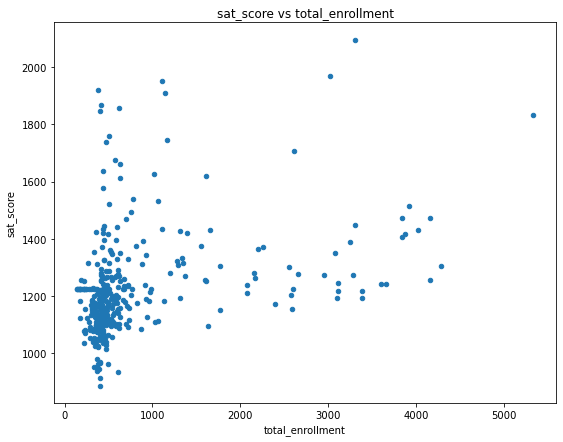

In [77]:
# Correlación entre 'total_enrollment' y 'sat_score'
combined.plot.scatter(x='total_enrollment', y='sat_score', title='sat_score vs total_enrollment',figsize=(9,7))
plt.show()

La correlación no se ve tan fuerte en el gráfico. 

Los valores del clúster en la parte inferior izquierda del gráfico sí parecen tener una fuerte correlación, y es posible que sea por esto por lo que el valor r sea tan alto.
Vamos a filtrar los valores que sean menores de 1000:

In [78]:
# Seleccionamos los valores menores que 1000
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]

In [79]:
# Mostramos las escuelas
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Las mayor parte de las escuelas que hemos mostrado son de estudiantes que no son nativos, que están aprendiendo inglés. Esto puede indicar que realmente es la columna *ell_percent* la que correlaciona con *sat_score*, en vez de *total_enrollment*.

### Correlación entre *ell_percent* y *sat_score*

Para explorar esta relación, vamos a graficar la correlación entre *ell_percent* contra *sat_score*:

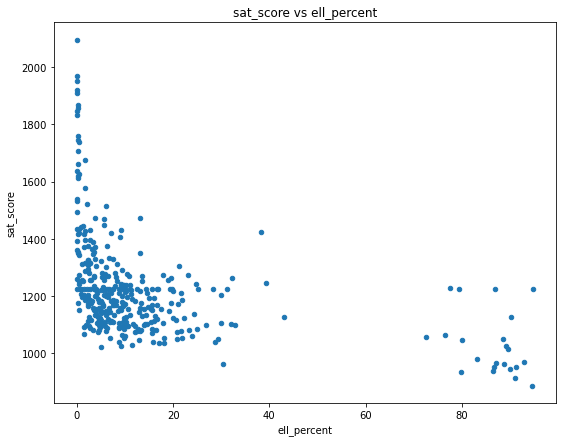

In [80]:
# Graficamos la correlación
combined.plot.scatter(x='ell_percent', y='sat_score', title='sat_score vs ell_percent', figsize=(9,7))
plt.show()

Vemos que esta correlación tiene más sentido y los puntos forman un patrón más definido. Tiene sentido que el porcentaje de los estudiantes no-nativos o estudiantes de inglés estén correlacionados negativamente con unas puntuaciones SAT más bajas.

Una manera de hacer más legibles las estadísticas granulares es agregarlas. En este caso, podemos agregar por Distrito Escolar, lo que puede permitirnos como *ell_percent* varía Distrito por Distrito en vez de la poco legible escuela por escuela.

Utilizaremos exactamente el mismo principio que utilizamos cuando agrupamos por 'DBN', pero en este caso buscaremos la media de cada columna por cada valor único en *school_dist*:

In [81]:
# Agrupamos por Distrito
by_district = combined.groupby('school_dist')

In [82]:
# Calculamos las medias de cada columna
districts = by_district.agg(np.mean)

In [83]:
# Reseteamos los índices
districts = districts.reset_index()

In [84]:
# Comprobamos 'districts'
districts.head()

,school_dist,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,1354.500000,173.019231,135.800000,116.681090,93.500000,1.0,115.244241,5.148538,22.675415,18.798392,26.553044,0.0,20112012.0,0.0,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,525.368056,38.500000,239.166667,8.233333,7.800000,7.683333,8.016667,7.066667,6.233333,6.700000,7.500000,6.768611,6.165787,6.736713,7.446898,7.433333,6.816667,7.116667,7.683333,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,1295.638184,201.516827,157.495833,128.908454,158.647849,2.0,149.818949,5.686360,25.038118,20.662667,28.593861,0.0,20112012.0,0.0,63.164583,605.604167,51.625000,13.006250,70.770833,13.212500,118.395833,14.479167,141.145833,24.733333,271.458333,49.554167,68.541667,10.056250,266.500000,44.718750,339.104167,55.281250,83.312500,86.416667,38.333333,495.171007,31.687500,190.000000,8.254167,7.495833,7.379167,7.704167,7.404167,6.520833,7.120833,7.564583,6.910660,6.204057,6.650422,7.385029,7.520833,6.720833,7.037500,7.541667,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,1293.443035,244.522436,193.087500,156.183494,183.384409,3.0,156.005994,5.839200,23.716311,19.737593,27.122831,0.0,20112012.0,0.0,58.050000,661.416667,36.916667,9.025000,63.583333,14.500000,68.000000,6.408333,181.833333,34.000000,228.250000,44.533333,172.000000,13.725000,272.166667,47.950000,389.250000,52.050000,83.166667,80.833333,36.166667,519.250000,28.166667,206.416667,8.316667,7.541667,7.508333,7.758333,6.675000,5.991667,6.533333,6.991667,6.716667,6.258333,6.633333,7.375000,7.233333,6.616667,6.891667,7.391667,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,1224.142857,183.879121,151.035714,129.016484,113.857143,4.0,132.362265,5.192610,24.101048,19.740816,27.460291,0.0,20112012.0,0.0,71.000000,569.285714,21.571429,4.557143,58.571429,13.214286,61.142857,6.128571,151.714286,30.028571,341.571429,61.400000,9.285714,1.314286,193.285714,30.514286,376.000000,69.485714,87.571429,92.714286,41.285714,504.857143,32.428571,193.142857,8.385714,7.657143,7.500000,7.928571,7.871429,7.042857,7.428571,7.885714,6.885714,6.114286,6.685714,7.571429,7.714286,6.942857,7.185714,7.785714,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,1285.062687,115.725275,142.464286,85.722527,143.677419,5.0,120.623901,4.845101,24.290247,20.447527,27.746703,0.0,20112012.0,0.0,58.671429,605.857143,21.571429,4.157143,59.714286,10.428571,32.714286,7.300000,342.571429,49.000000,195.571429,36.214286,31.285714,6.714286,300.000000,48.471429,305.857143,51.528571,82.857143,79.285714,40.428571,442.428571,27.714286,184.857143,8.085714,7.342857,7.357143,7.685714,6.857143,5.885714,6.242857,6.957143,6.314286,6.000000,6.428571,7.285714,7.085714,6.414286,6.671429,7.314286,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


Vamos a graficar las puntuaciones SAT por Distrito:

In [85]:
# Extraemos las dos columnas que formarán el gráfico
dist_sat = districts[['school_dist', 'sat_score']]

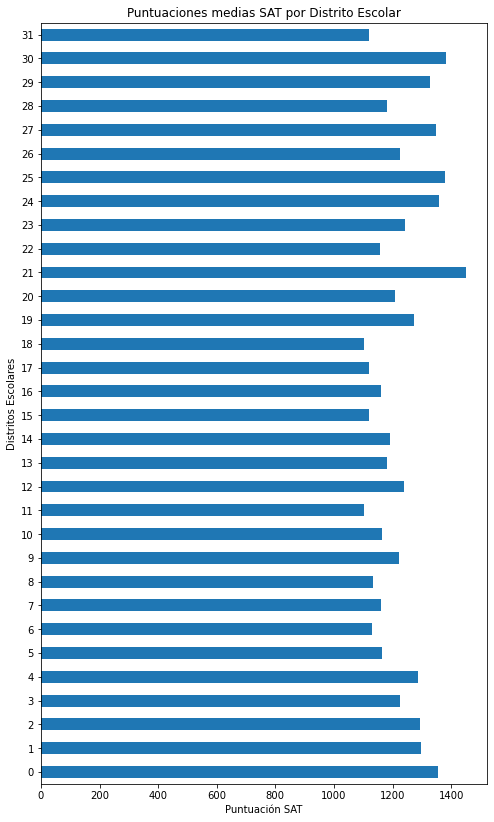

In [86]:
# Creamos un gráfico de barras horizontales
dist_sat.plot(kind='barh', figsize=(8,14), legend=False, title='Puntuaciones medias SAT por Distrito Escolar')
plt.xlabel('Puntuación SAT')
plt.ylabel('Distritos Escolares')
plt.show()

#### **Los Distritos con mayores puntuaciones medias SAT son:**

- Distrito 21 (Brooklyn)
- Distrito 25 (Queens)
- Distrito 30 (Queens)
- Distrito 24 (Queens)
- Distrito 29 (Queens)

**Los Distritos con menores puntuaciones medias SAT son:**
 
- Distrito 6 (Manhattan)
- Distrito 8 (Bronx)
- Distrito 18 (Brooklyn)
- Distrito 11 (Bronx)
- Distrito 15 (Brooklyn)

Cuatro de los cinco Distritos Escolares con las notas medias más elevadas se encuentran en Queens, mientras que de los cinco con peores notas medias, 2 son del Bronx, 2 de Brooklyn y uno de Manhattan.

Esta información está disponible en la columna *boro* en el DataFrame.

Vamos a ver un poco más en profundidad las puntuaciones por borough:

In [87]:
# Agrupamos por boroughs
boroughs = combined.groupby('boro')

In [88]:
# Sacamos las medias
boroughs_mean = boroughs.agg(np.mean)
boroughs_mean = boroughs_mean.reset_index()
boroughs_mean

,boro,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,Bronx,1157.598203,149.445409,135.694086,96.473842,136.857093,9.548387,123.113090,5.011787,23.894857,19.253574,27.982096,0.0,20112012.0,0.0,75.156989,578.236559,89.752688,18.245161,94.010753,16.587097,38.419355,3.283871,167.483871,30.237634,343.365591,63.169892,25.376344,2.709677,301.172043,50.319355,277.053763,49.678495,80.440860,80.784946,42.440860,435.959229,30.559140,202.333333,8.346237,7.805376,7.639785,7.947312,7.026882,6.397849,6.884946,7.427957,6.606577,6.093492,6.630326,7.418079,7.322581,6.765591,7.046237,7.598925,12.0,12.0,10461.408602,549.569892,1.344086,0.0,0.0,0.0,40.845473,-73.890973
1,Brooklyn,1181.364461,202.857765,164.940094,131.645682,183.870968,18.000000,168.902227,6.373460,24.624036,19.652370,28.616222,0.0,20112012.0,0.0,68.186792,775.613208,88.943396,11.327358,100.481132,14.794340,129.575472,7.376415,335.207547,56.233962,196.962264,28.701887,109.622642,7.037736,405.037736,51.499057,370.575472,48.500000,77.952830,82.122642,34.783019,575.726415,39.179245,249.754717,8.036792,7.600000,7.516981,7.789623,6.985849,6.509434,6.979245,7.497170,6.370755,6.028302,6.549057,7.313208,7.129245,6.715094,7.016038,7.535849,12.0,12.0,11216.150943,751.556604,1.971698,0.0,0.0,0.0,40.665555,-73.947829
2,Manhattan,1278.331410,192.661966,153.337778,126.135363,155.421505,2.900000,143.512969,5.522550,24.605099,20.314768,28.176947,0.0,20112012.0,0.0,64.806667,616.233333,57.033333,12.822222,69.788889,13.618889,89.344444,10.878889,155.444444,26.634444,289.522222,52.272222,75.600000,9.127778,275.733333,45.700000,340.500000,54.300000,83.322222,85.211111,39.900000,495.615741,31.566667,203.255556,8.288889,7.577778,7.465556,7.786667,7.287778,6.432222,6.963333,7.472222,6.831370,6.179883,6.644895,7.408475,7.473333,6.728889,7.021111,7.556667,12.0,12.0,10024.744444,633.588889,1.433333,0.0,0.0,0.0,40.766244,-73.975350
3,Queens,1286.753032,238.014423,153.975000,160.463942,307.208165,26.906250,254.299343,9.143399,26.128505,20.314646,30.070502,0.0,20112012.0,0.0,55.751562,1217.406250,154.140625,11.882813,131.015625,10.442188,346.359375,23.670313,276.750000,30.064062,434.812500,33.646875,149.406250,11.757812,624.593750,49.248438,592.812500,50.751562,82.000000,84.796875,38.718750,878.234375,57.046875,318.843750,8.098437,7.476563,7.425000,7.685937,7.365625,6.789063,7.139063,7.668750,6.721875,6.090625,6.664063,7.410938,7.387500,6.779687,7.073438,7.593750,12.0,12.0,11343.000000,1187.187500,2.390625,0.0,0.0,0.0,40.715715,-73.836422
4,Staten Island,1382.500000,355.111538,194.435000,228.908654,450.787097,31.000000,380.528319,13.251284,28.119729,19.995494,32.785641,0.0,20112012.0,0.0,38.310000,1850.600000,64.200000,2.860000,301.500000,16.710000,177.700000,10.300000,307.300000,18.270000,418.700000,22.170000,938.700000,48.810000,948.500000,52.090000,902.100000,47.910000,88.900000,91.300000,43.500000,1476.600000,88.900000,593.300000,7.800000,7.390000,7.460000,7.620000,7.210000,7.140000,7.390000,7.860000,6.530000,6.070000,6.780000,7.330000,7.200000,6.870000,7.200000,7.610000,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726


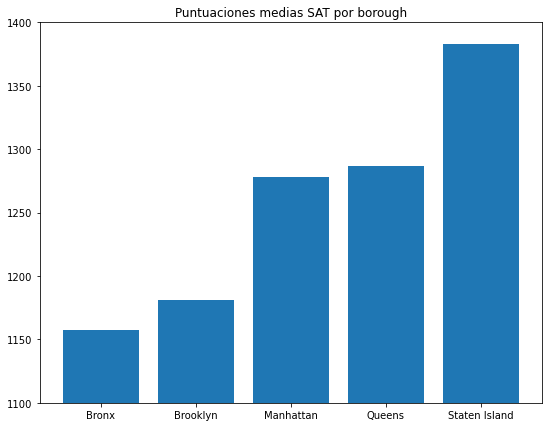

In [89]:
# Graficamos las medias
borough_sat = boroughs_mean['sat_score']
boroughs_list = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
# Construimos el gráfico
plt.figure(figsize=(9,7))
plt.bar(boroughs_list, borough_sat)
plt.title('Puntuaciones medias SAT por borough')
plt.ylim(1100,1400)
plt.show()

Aunque en Queens están las escuelas con mayores puntuaciones medias, vemos que claramente las puntuaciones medias más altas están en Staten Island.

Sí es cierto que las puntuaciones medias más bajas están en Bronx, seguido de cerca por Brooklyn. 

Entre medias, están Manhattan y Queens, con unas medias parecidas, cercanas a los 1300.

### Correlación entre las encuestas y *sat_score*

Tenemos datos sobre encuestas a alumnos, profesores y padres. Queremos ver la correlación que tienen estos valores con *sat_score*.

Las columnas que se refieren a las encuestas arriba mencionadas son las siguientes (las hemos agregado directamente a una lista por comodidad):

In [90]:
# Lista con las columnas relativas a encuestas. Agregamos también 'sat_score' para crear un DataFrame
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    "sat_score"
]

In [91]:
# Correlación entre las encuestas y 'sat_score'. Primero creamos un DataFrame
survey_sat_scores = combined[survey_fields]
surv_sat_corr = survey_sat_scores.corr()

In [92]:
# Mostramos las correlaciones de 'sat_score' con los demás campos
surv_sat_corr['sat_score']

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64

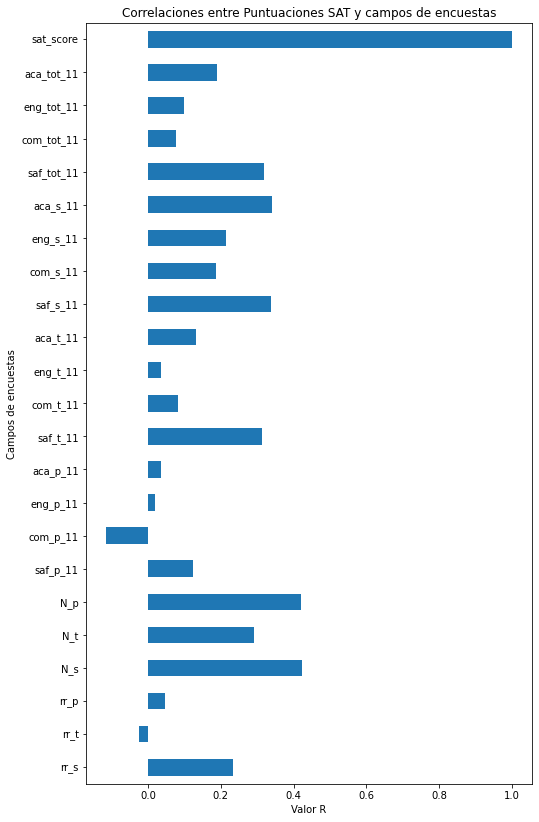

In [93]:
surv_sat_corr['sat_score'].plot(kind='barh', figsize=(8,14), title='Correlaciones entre Puntuaciones SAT y campos de encuestas')
plt.ylabel('Campos de encuestas')
plt.xlabel('Valor R')
plt.show()

Las correlaciones más fuertes son:

- **N_p** número de padres encuestados
- **N_s** número de estudiantes encuestados
- **aca_s_11** Puntuación SAT esperada basada en las respuestas de los estudiantes
- **saf_s_11** Puntuación de seguridad y respeto basado en las respuestas de los estudiantes
- **saf_t_11** Puntuación de seguridad y respeto basado en las respuestas de los profesores

Podemos observar que la puntuación de seguridad y respeto correlacionan de manera muy fuerte con las puntuaciones SAT de los estudiantes.

Tanto las respuestas sobre seguridad y respeto de los profesores como las de los alumnos tienen prácticamente el mismo valor R, por lo que vamos a ver esto en más detalle.

Vamos a ver las escuelas con peores puntuaciones de seguridad:

In [94]:
# Creamos un DataFrame con puntuaciones de seguridad, nombre de las escuelas y puntuaciones SAT
safety = combined[['school_name', 'saf_s_11', 'saf_t_11', 'sat_score']]

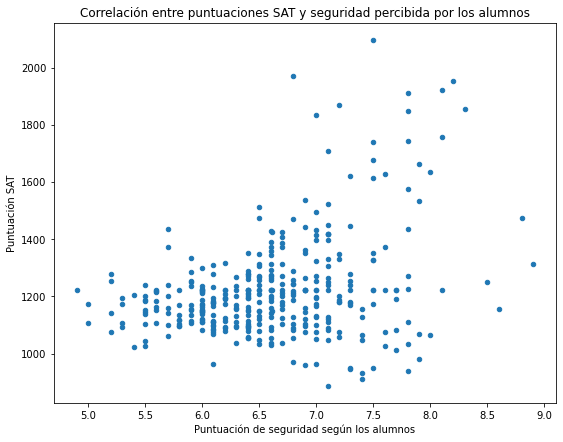

In [95]:
# Correlación entre 'sat_score' y 'saf_s_11'
combined.plot.scatter(figsize=(9,7),y='sat_score', x='saf_s_11', title='Correlación entre puntuaciones SAT y seguridad percibida por los alumnos')
plt.xlabel('Puntuación de seguridad según los alumnos')
plt.ylabel('Puntuación SAT')
plt.show()

Efectivamente, vemos como según las puntuaciones de seguridad aumentan, lo hacen también las puntuaciones SAT.

Todas las puntuaciones SAT medias por encima de 1600 puntos pertenecen a escuelas que tienen más de un 7 de puntuación de seguridad.

### Puntuaciones de seguridad por boroughs

Ya que hemos corroborado que las puntuaciones SAT tienen una fuerte correlación con la seguridad de las escuelas, sería interesante comprobar la puntuación media de seguridad por borough, para ver si el patrón es similar al de las puntuaciones por borough.

Para ello, reutilizaremos el DataFrame *boroughs_mean* que ya teníamos creado, pero esta vez graficaremos las puntuaciones de seguridad por borough:

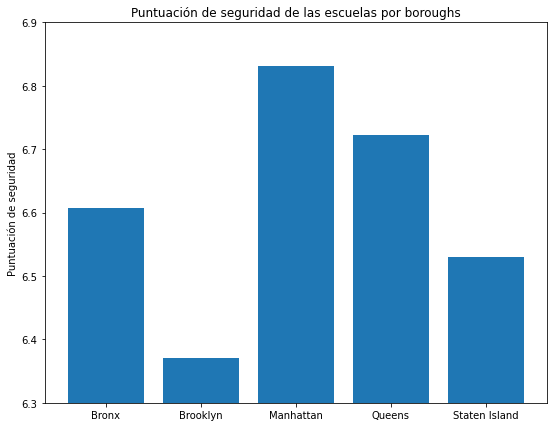

In [96]:
# Construimos el gráfico
plt.figure(figsize=(9,7))
plt.bar(boroughs_mean['boro'],boroughs_mean['saf_s_11'])
plt.ylim(6.3,6.9)
plt.title('Puntuación de seguridad de las escuelas por boroughs')
plt.ylabel('Puntuación de seguridad')
plt.show()

Claramente Brooklyn es el borough donde los estudiantes perciben (de media) más inseguridad en las escuelas, mientras que Manhattan es donde más seguridad perciben.

Curiosamente, Staten Island (que es el borough que más puntuación SAT media tiene), es el segundo más inseguro según los alumnos (de media), seguido de cerca por Bronx.

La inseguridad percibida por los alumnos en Brooklyn y la seguridad de Queens hacen que la correlación sea tan fuerte.

## Correlación entre razas y puntuaciones SAT

Si graficamos la correlación existente entre los distintos grupos raciales y las puntuaciones SAT, podremos determinar si existe (de media) diferencia de rendimiento entre unos grupos y otros.

Para ello, primeramente debemos agrupar el DataFrame según los grupos raciales de los alumnos.

Las columnas relacionadas con el porcentaje de alumnos según sus grupos raciales son las siguientes:

- white_per
- asian_per
- black_per
- hispanic_per

In [97]:
# Agrupamos por grupos raciales
white_grouped = combined.groupby('white_per')
asian_grouped = combined.groupby('asian_per')
black_grouped = combined.groupby('black_per')
hispanic_grouped = combined.groupby('hispanic_per')

In [98]:
# Calculamos las medias
white_grouped_mean = white_grouped.agg(np.mean)
asian_grouped_mean = asian_grouped.agg(np.mean)
black_grouped_mean = black_grouped.agg(np.mean)
hispanic_grouped_mean = hispanic_grouped.agg(np.mean)

# Reseteamos índices
white_grouped_mean = white_grouped_mean.reset_index()
asian_grouped_mean = asian_grouped_mean.reset_index()
black_grouped_mean = black_grouped_mean.reset_index()
hispanic_grouped_mean = hispanic_grouped_mean.reset_index()

Vamos a echar un vistazo a las correlaciones:

### Correlación entre porcentaje de alumnos de raza blanca y puntuaciones SAT 

In [99]:
# Mostramos las correlaciones de 'white_per'
white_grouped_mean.corr()['white_per'].head()

white_per                               1.000000
sat_score                               0.582430
Total Exams Taken                       0.197370
Number of Exams with scores 3 4 or 5    0.133388
AP Test Takers                          0.208513
Name: white_per, dtype: float64

La correlación entre el porcentaje de alumnos de raza blanca y las puntuaciones SAT es de 0.582

### Correlación entre porcentaje de alumnos de raza asiática y puntuaciones SAT 

In [100]:
# Mostramos las correlaciones de 'asian_per'
asian_grouped_mean.corr()['asian_per'].head()

asian_per                               1.000000
sat_score                               0.510572
Total Exams Taken                       0.450294
Number of Exams with scores 3 4 or 5    0.425432
AP Test Takers                          0.461629
Name: asian_per, dtype: float64

La correlación entre el porcentaje de alumnos de raza blanca y las puntuaciones SAT es de 0.510

### Correlación entre porcentaje de alumnos de raza negra y puntuaciones SAT 

In [101]:
# Mostramos las correlaciones de 'black_per'
asian_grouped_mean.corr()['black_per'].head()

asian_per                              -0.580636
sat_score                              -0.465102
Total Exams Taken                      -0.284742
Number of Exams with scores 3 4 or 5   -0.220104
AP Test Takers                         -0.299448
Name: black_per, dtype: float64

La correlación entre el porcentaje de alumnos de raza negra y las puntuaciones SAT es de -0.465

### Correlación entre porcentaje de alumnos de raza hispana y puntuaciones SAT 

In [102]:
# Mostramos las correlaciones de 'hispanic_per'
asian_grouped_mean.corr()['hispanic_per'].head()

asian_per                              -0.553543
sat_score                              -0.568931
Total Exams Taken                      -0.346485
Number of Exams with scores 3 4 or 5   -0.348309
AP Test Takers                         -0.352006
Name: hispanic_per, dtype: float64

La correlación entre el porcentaje de alumnos de raza hispana y las puntuaciones SAT es de -0.568

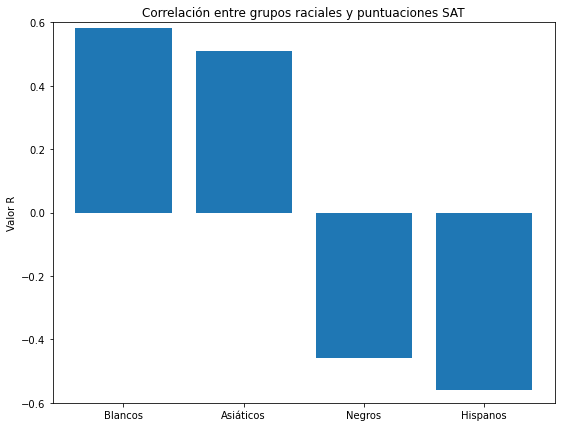

In [103]:
# Graficamos las correlaciones
rac_gr = ['Blancos', 'Asiáticos', 'Negros', 'Hispanos']
punt = [0.582, 0.51, -0.46, -0.56]
# Construimos el gráfico
plt.figure(figsize=(9,7))
plt.bar(rac_gr, punt)
plt.ylim(-0.6,0.6)
plt.ylabel('Valor R')
plt.title('Correlación entre grupos raciales y puntuaciones SAT')
plt.show()

Los grupos raciales blancos y asiáticos rinden a un nivel opuesto al de negros e hispanos.

Mientras que las puntuaciones SAT en los primeros tienen fuerte correlación positiva, los de los segundos tienen fuerte correlación negativa. 

Esto puede deberse a factores socio-económicos de la ciudad de Nueva York que no entraremos a estudiar en este análisis.

Vamos a ver las puntuaciones medias por grupos raciales. Veremos las medias cuando más de el 50% de los alumnos son del mismo grupo racial para obtener unos resultados más o menos precisos. No disponemos de suficientes datos como para utilizar un porcentaje más elevado.

In [104]:
# Grupos de alumnos donde más de la mitad pertenecen al grupo racial blanco
white_groups = white_grouped_mean[white_grouped_mean['white_per'] > 50]
# Puntuación SAT media (blancos)
white_groups['sat_score'].mean()

1516.4545454545455

In [105]:
# Grupos de alumnos donde más de la mitad pertenecen al grupo racial asiático
asian_groups = asian_grouped_mean[asian_grouped_mean['asian_per'] > 50]
# Puntuación SAT media (asiáticos)
asian_groups['sat_score'].mean()

1622.090909090909

In [106]:
# Grupos de alumnos donde más de la mitad pertenecen al grupo racial negro
black_groups = black_grouped_mean[black_grouped_mean['black_per'] > 50]
# Puntuación SAT media (negros)
black_groups['sat_score'].mean()

1161.3946426404564

In [107]:
# Grupos de alumnos donde más de la mitad pertenecen al grupo racial hispano
hispanic_groups = hispanic_grouped_mean[hispanic_grouped_mean['hispanic_per'] > 50]
# Puntuación SAT media (hispanos)
hispanic_groups['sat_score'].mean()

1163.4494998459031

En las clases donde al menos el 50% de los alumnos son del mismo grupo racial, las puntuaciones SAT medias fueron las siguientes:

- Blancos: 1516.45
- Asiáticos: 1622.09
- Negros: 1161.39
- Hispanos: 1163.44

Vamos a visualizar los resultados:

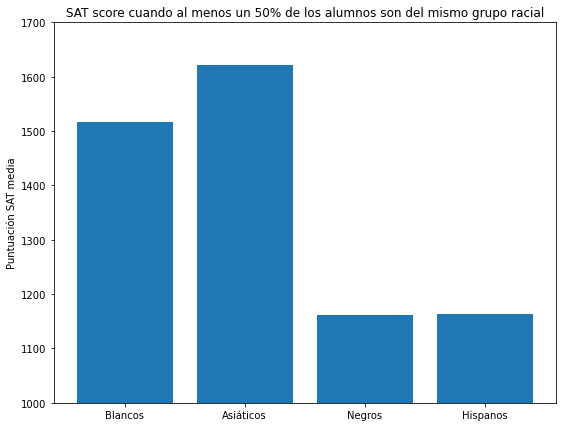

In [108]:
# Graficamos los resultados
pun = [1516.45, 1622.09, 1161.39, 1163.44]
raz = ['Blancos', 'Asiáticos', 'Negros', 'Hispanos']
# Construimos el gráfico
plt.figure(figsize=(9,7))
plt.bar(raz, pun)
plt.title('SAT score cuando al menos un 50% de los alumnos son del mismo grupo racial')
plt.ylabel('Puntuación SAT media')
plt.ylim(1000, 1700)
plt.show()

Vamos a ver si existen datos donde la cantidad de alumnos según su grupo racial sea muy alta, para intentar obtener datos más precisos:

In [109]:
# Grupos de alumnos donde más del 80% pertenecen al grupo racial blanco
white_groups_80 = white_grouped_mean[white_grouped_mean['white_per'] > 80]
# Mostramos los DataFrames
white_groups_80

,white_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
141,82.1,1418.0,687.0,206.0,396.0,1069.0,31.0,664.263158,21.368421,30.2,21.894737,34.052632,0.0,20112012.0,0.0,18.4,3875.0,55.0,1.4,540.0,13.9,210.0,5.4,82.0,2.1,385.0,9.9,3181.0,1923.0,49.6,1952.0,50.4,85.0,94.0,30.0,3165.0,189.0,998.0,7.6,7.0,7.4,7.4,7.7,7.5,7.8,8.0,7.1,6.2,7.5,7.8,7.4,6.9,7.5,7.7,12.0,12.0,10312.0,3957.0,4.0,0.0,0.0,0.0,40.528229,-74.192154


In [110]:
# Grupos de alumnos donde más del 80% pertenecen al grupo racial asiático
asian_groups_80 = asian_grouped_mean[asian_grouped_mean['asian_per'] > 80]
# Mostramos los DataFrames
asian_groups_80

,asian_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
170,89.5,1424.0,96.0,89.0,61.0,54.0,2.0,92.058824,4.294118,21.817647,16.588235,26.294118,0.0,20112012.0,0.0,82.6,353.0,135.0,38.2,8.0,2.3,316.0,12.0,3.4,14.0,4.0,8.0,2.3,181.0,51.3,172.0,48.7,0.0,68.0,49.0,598.208333,19.0,158.0,8.6,7.1,7.1,7.4,7.5,5.6,5.8,6.8,6.611667,6.094722,6.620278,7.381389,7.9,6.2,6.3,6.9,12.0,12.0,10002.0,410.0,1.0,0.0,0.0,0.0,40.716867,-73.989532


In [111]:
# Grupos de alumnos donde más del 80% pertenecen al grupo racial negro
black_groups_80 = black_grouped_mean[black_grouped_mean['black_per'] > 80]
# Mostramos los DataFrames
black_groups_80

,black_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
259,81.1,1106.000000,22.000000,153.450000,22.000000,95.000000,19.0,96.250000,3.937500,23.993750,19.062500,29.125000,0.0,20112012.0,0.0,72.600000,380.000000,16.000000,4.200000,56.000000,14.70,8.000000,2.10,308.000000,54.000000,14.200000,5.000000,1.30,140.000000,36.800000,240.000000,63.200000,71.0,91.0,32.000000,265.000000,21.000000,118.000000,7.600000,7.000000,7.00,7.300000,5.800000,5.90,6.300000,7.40,5.300000,5.700000,5.600000,6.900000,6.300000,6.20,6.300000,7.200000,12.0,12.0,11207.000000,309.000000,2.000000,0.0,0.0,0.0,40.667553,-73.894801
260,81.5,1149.000000,197.038462,153.450000,129.028846,111.000000,19.0,82.928571,3.285714,24.614286,17.571429,28.928571,0.0,20112012.0,0.0,76.000000,453.000000,22.000000,4.900000,89.000000,19.60,3.000000,0.70,369.000000,79.000000,17.400000,0.000000,0.00,233.000000,51.400000,220.000000,48.600000,71.0,100.0,52.000000,278.000000,29.000000,202.000000,8.000000,7.900000,7.80,8.200000,7.600000,8.30,8.200000,8.80,6.500000,6.000000,7.100000,7.700000,7.400000,7.40,7.700000,8.200000,12.0,12.0,11207.000000,428.000000,3.000000,0.0,0.0,0.0,40.667553,-73.894801
261,82.3,1135.000000,197.038462,153.450000,129.028846,193.870968,18.0,86.375000,4.250000,20.562500,17.000000,23.375000,0.0,20112012.0,0.0,76.400000,305.000000,34.000000,11.100000,38.000000,12.50,7.000000,2.30,251.000000,32.000000,10.500000,12.000000,3.90,191.000000,62.600000,114.000000,37.400000,70.0,80.0,43.000000,175.000000,16.000000,102.000000,8.200000,7.300000,7.10,7.700000,6.800000,5.70,5.900000,6.00,6.100000,5.900000,6.600000,7.200000,7.000000,6.30,6.500000,7.000000,12.0,12.0,11236.000000,312.000000,1.000000,0.0,0.0,0.0,40.641844,-73.898687
262,82.5,1273.000000,130.000000,13.000000,106.000000,93.000000,17.0,104.111111,4.500000,23.116667,19.000000,26.111111,0.0,20112012.0,0.0,70.300000,417.000000,2.000000,0.500000,17.000000,4.10,15.000000,3.60,344.000000,51.000000,12.200000,3.000000,0.70,104.000000,24.900000,313.000000,75.100000,83.0,43.0,29.000000,329.000000,10.000000,112.000000,8.700000,8.000000,7.90,8.600000,7.900000,6.50,7.200000,7.70,6.400000,6.000000,6.500000,7.600000,7.700000,6.80,7.200000,8.000000,12.0,12.0,11203.000000,439.000000,3.000000,0.0,0.0,0.0,40.659517,-73.942546
263,82.8,1176.500000,119.019231,81.225000,83.014423,89.500000,23.0,82.875000,3.211806,25.682639,21.534722,29.475694,0.0,20112012.0,0.0,55.650000,427.500000,6.000000,1.400000,57.500000,13.40,11.500000,2.65,354.000000,53.000000,12.500000,3.000000,0.75,193.500000,44.850000,234.000000,55.150000,80.0,90.5,33.500000,329.500000,24.000000,132.500000,7.350000,7.000000,6.95,7.350000,6.950000,7.00,7.400000,7.75,5.800000,5.900000,6.400000,7.250000,6.700000,6.60,6.950000,7.450000,12.0,12.0,11319.000000,439.500000,1.000000,0.0,0.0,0.0,40.669266,-73.859244
264,83.6,1068.000000,197.038462,153.450000,129.028846,71.000000,16.0,79.538462,3.615385,22.307692,16.230769,28.000000,0.0,20112012.0,0.0,71.000000,439.000000,6.000000,1.400000,75.000000,17.10,4.000000,0.90,367.000000,62.000000,14.100000,2.000000,0.50,214.000000,48.700000,225.000000,51.300000,81.0,92.0,29.000000,372.000000,36.000000,124.000000,7.900000,7.200000,7.20,7.500000,6.200000,6.00,6.300000,6.80,6.100000,5.500000,6.600000,7.300000,6.700000,6.20,6.700000,7.200000,12.0,12.0,11221.000000,1

In [112]:
# Grupos de alumnos donde más del 80% pertenecen al grupo racial hispano
hispanic_groups_80 = hispanic_grouped_mean[hispanic_grouped_mean['hispanic_per'] > 80]
# Mostramos los DataFrames
hispanic_groups_80

,hispanic_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
254,80.6,1085.000000,16.000000,12.00,16.000000,100.000000,14.0,114.642857,3.857143,30.050000,26.500000,32.285714,0.0,20112012.0,0.0,76.60,865.0,215.0,24.90,231.0,26.7,2.0,0.20,132.0,15.30,697.0,29.0,3.4,473.0,54.70,392.0,45.30,77.0,84.0,29.0,661.0,64.0,221.0,8.00,7.50,7.40,7.70,7.10,6.70,7.10,7.50,6.10,5.80,6.50,7.40,7.10,6.70,7.00,7.50,12.0,12.0,11206.0,778.0,4.0,0.0,0.0,0.0,40.703577,-73.953237
255,80.8,1223.438806,197.038462,153.45,129.028846,193.870968,15.0,376.777778,13.888889,26.855556,24.000000,30.444444,0.0,20112012.0,0.0,79.90,988.0,142.0,14.40,220.0,22.3,46.0,4.70,77.0,7.80,798.0,66.0,6.7,501.0,50.70,487.0,49.30,95.0,98.0,47.0,629.0,51.0,304.0,8.30,7.90,7.90,8.10,7.00,7.00,7.80,8.40,6.40,6.40,6.90,7.30,7.20,7.10,7.50,7.90,12.0,12.0,11232.0,1309.0,1.0,0.0,0.0,0.0,40.655953,-74.005497
256,81.9,1181.000000,54.000000,17.00,40.000000,115.000000,10.0,125.066667,4.600000,26.266667,20.133333,30.600000,0.0,20112012.0,0.0,77.90,1126.0,136.0,12.10,161.0,14.3,45.0,4.00,134.0,11.90,922.0,23.0,2.0,551.0,48.90,575.0,51.10,90.0,91.0,51.0,978.0,72.0,496.0,8.60,7.60,7.60,7.90,7.40,6.20,6.60,7.20,6.50,6.20,6.60,7.50,7.50,6.70,6.90,7.50,12.0,12.0,10463.0,1036.0,1.0,0.0,0.0,0.0,40.880050,-73.909209
257,83.2,1223.438806,197.038462,153.45,129.028846,193.870968,8.0,53.400000,3.000000,19.080000,17.200000,21.000000,0.0,20112012.0,0.0,87.20,155.0,123.0,79.40,12.0,7.7,8.0,5.20,13.0,8.40,129.0,4.0,2.6,81.0,52.30,74.0,47.70,99.0,100.0,81.0,76.0,5.0,61.0,8.80,8.30,7.60,8.50,9.30,7.80,9.60,9.80,6.90,6.30,6.60,7.10,8.30,7.50,7.90,8.50,12.0,12.0,10473.0,313.0,1.0,0.0,0.0,0.0,40.822304,-73.855961
258,83.8,1224.000000,38.000000,17.00,32.000000,158.000000,6.0,139.937500,5.062500,27.631250,22.437500,31.312500,0.0,20112012.0,0.0,90.70,679.0,212.0,31.20,94.0,13.8,5.0,0.70,93.0,13.70,569.0,7.0,1.0,358.0,52.70,321.0,47.30,92.0,100.0,47.0,625.0,44.0,310.0,8.30,8.00,7.70,7.90,7.00,7.10,7.50,7.90,6.40,5.80,6.50,7.20,7.20,6.90,7.20,7.70,12.0,12.0,10040.0,624.0,1.0,0.0,0.0,0.0,40.855938,-73.927030
259,84.4,1102.000000,212.000000,82.00,141.000000,171.000000,6.0,152.722222,6.111111,24.966667,19.055556,31.000000,0.0,20112012.0,0.0,72.50,694.0,222.0,32.00,116.0,16.7,7.0,1.00,90.0,13.00,586.0,9.0,1.3,407.0,58.60,287.0,41.40,74.0,67.0,43.0,451.0,28.0,255.0,8.50,8.20,8.00,8.30,6.90,6.50,6.90,7.60,6.50,6.00,6.60,7.40,7.30,6.90,7.10,7.80,12.0,12.0,10040.0,679.0,1.0,0.0,0.0,0.0,40.855938,-73.927030
260,84.6,1081.219403,197.038462,153.45,129.028846,122.935484,7.0,103.166667,4.600000,23.093333,17.266667,27.866667,0.0,20112012.0,0.0,94.05,272.0,235.5,86.65,7.0,3.7,10.0,4.35,27.0,9.40,230.0,2.0,0.8,144.0,53.45,128.0,46.55,95.5,100.0,61.5,211.0,16.5,145.0,9.05,8.05,7.85,8.00,8.25,7.70,8.50,8.45,7.75,6.10,7.40,7.70,8.35,7.25,7.95,8.05,12.0,12.0,10244.0,350.0,1.0,0.0,0.0,0.0,40.788736,-73.929916
261,84.7,962.000000,37.000000,153.45,32.000000,118.000000,10.0,195.071429,6.571429,29.628571,27.000000,32.428571,0.0,20112012.0,0.0,95.10,497.0,441.0,88.70,2.0,0.4,34.0,6.80,27.0,5.40,421.0,15.0,3.0,260.0,52.30,237.0,47.70,84.0,88.0,36.0,389.0,21.0,155.0,8.20,7.90,7.50,7.90,6.90,6.00,7.60,7.90,6.90,6.00,6.60,7.40,7.30,6.60,7.20,7.70,12.0,12.0,10468.0,443.0,1.0,0.0,0.0,0.0,40.870377,-73.898163
262,87.1,1098.000000,64.000000,153.45,37.000000,161.000000

Solo tenemos una clase donde más del 80% de los alumnos son blancos, y una clase donde más del 80% de los alumnos son asiáticos.

Sin embargo, tenemos múltiples clases donde más del 80% son negros o más del 80% son hispanos. De éstos, calcularemos las medias y graficaremos los resultados.

In [113]:
# Medias grupo racial negro
black_groups_80_mean =  black_groups_80['sat_score'].mean()
black_groups_80_mean

1153.6907960199005

In [114]:
# Medias grupo racial hispano
hispanic_groups_80_mean =  hispanic_groups_80['sat_score'].mean()
hispanic_groups_80_mean

1106.6498341625206

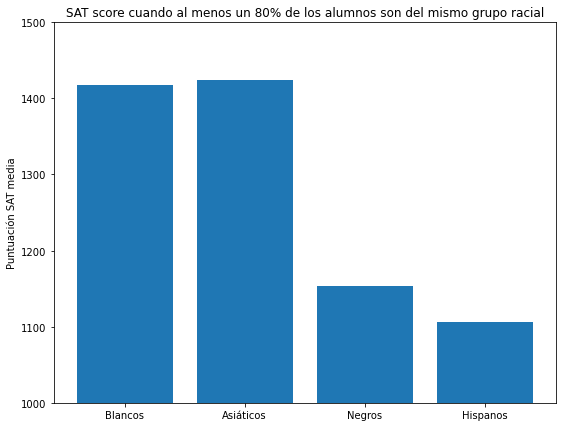

In [115]:
# Graficamos los resultados
pun = [1418, 1424, 1153.69, 1106.64]
raz = ['Blancos', 'Asiáticos', 'Negros', 'Hispanos']
# Construimos el gráfico
plt.figure(figsize=(9,7))
plt.bar(raz, pun)
plt.title('SAT score cuando al menos un 80% de los alumnos son del mismo grupo racial')
plt.ylabel('Puntuación SAT media')
plt.ylim(1000, 1500)
plt.show()

El aspecto del gráfico es similar al anterior (cuando al menos el 50% de los alumnos pertenecían al mismo grupo racial), pero las diferencias no son tan abultadas.

### Correlación entre sexos y puntuaciones SAT

Vamos a analizar ahora la correlación existente entre los dos sexos (hombres y mujeres) y las puntuaciones SAT.

Agruparemos según el porcentaje de alumnos por sexos y veremos las puntuaciones medias:

In [116]:
# Agrupamos por sexos
male_group = combined.groupby('male_per')
female_group = combined.groupby('female_per')

In [117]:
# Medias
male_group_mean = male_group.agg(np.mean)
female_group_mean = female_group.agg(np.mean)
# Reseteamos índices
male_group_mean = male_group_mean.reset_index()
female_group_mean = female_group_mean.reset_index()

In [118]:
# Mostramos las medias (hombres)
male_group_mean.head()

,male_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,0.0,1252.18806,149.456044,135.671429,98.877747,136.78341,14.428571,71.527911,3.118347,22.665436,20.090136,24.889656,0.0,20112012.0,0.0,68.485714,446.285714,19.428571,4.6,45.285714,10.514286,73.571429,16.271429,181.142857,40.528571,164.857143,37.285714,22.428571,4.971429,0.0,446.285714,100.0,90.0,93.428571,55.714286,362.714286,24.285714,218.285714,8.471429,7.757143,7.671429,7.942857,7.728571,6.971429,7.328571,7.914286,7.085714,6.571429,7.071429,7.942857,7.757143,7.1,7.357143,7.914286,12.0,12.0,10714.428571,494.857143,1.0,0.0,0.0,0.0,40.728519,-73.943820
1,0.3,1171.00000,22.000000,153.450000,21.000000,75.00000,8.000000,94.533333,4.333333,22.000000,18.133333,25.666667,0.0,20112012.0,0.0,72.200000,379.000000,10.000000,2.6,59.000000,15.600000,11.000000,2.900000,174.000000,45.900000,176.000000,46.400000,9.000000,2.400000,1.0,378.000000,99.7,87.0,95.000000,20.000000,265.000000,21.000000,59.000000,8.100000,7.000000,6.800000,6.900000,7.300000,6.000000,6.100000,6.600000,6.300000,5.400000,5.600000,6.900000,7.200000,6.1,6.100000,6.800000,12.0,12.0,10473.000000,395.000000,1.0,0.0,0.0,0.0,40.814918,-73.856566
2,7.3,1257.00000,87.000000,26.000000,70.000000,416.00000,2.000000,409.250000,13.416667,30.608333,26.916667,32.750000,0.0,20112012.0,0.0,68.300000,1599.000000,45.000000,2.8,184.000000,11.500000,60.000000,3.800000,626.000000,39.100000,836.000000,52.300000,66.000000,4.100000,116.0,1483.000000,92.7,94.0,91.000000,17.000000,1495.000000,85.000000,263.000000,7.900000,6.800000,7.100000,7.300000,7.400000,7.200000,7.300000,7.700000,6.500000,5.600000,6.500000,7.300000,7.300000,6.5,6.900000,7.400000,12.0,12.0,10011.000000,1732.000000,1.0,0.0,0.0,0.0,40.745112,-73.995906
3,14.6,1039.00000,197.038462,153.450000,129.028846,47.00000,9.000000,30.000000,1.375000,22.500000,20.625000,24.500000,0.0,20112012.0,0.0,84.300000,323.000000,28.000000,8.7,72.000000,22.300000,1.000000,0.300000,119.000000,36.800000,202.000000,62.500000,0.000000,0.000000,47.0,276.000000,85.4,87.0,88.000000,30.000000,192.000000,15.000000,62.000000,8.600000,7.900000,7.900000,8.100000,6.800000,6.100000,7.000000,7.300000,6.600000,6.000000,6.800000,7.400000,7.300000,6.7,7.200000,7.600000,12.0,12.0,10456.000000,378.000000,1.0,0.0,0.0,0.0,40.827603,-73.904475
4,16.5,1157.00000,15.000000,153.450000,15.000000,67.00000,10.000000,108.437500,4.250000,25.812500,19.875000,32.062500,0.0,20112012.0,0.0,71.500000,540.000000,36.000000,6.7,84.000000,15.600000,8.000000,1.500000,192.000000,35.600000,310.000000,57.400000,18.000000,3.300000,89.0,451.000000,83.5,62.0,59.000000,47.000000,287.000000,17.000000,212.000000,8.100000,7.600000,7.400000,7.800000,6.000000,5.400000,6.100000,6.400000,5.900000,5.900000,5.900000,6.900000,6.700000,6.3,6.500000,7.000000,12.0,12.0,10463.000000,573.000000,1.0,0.0,0.0,0.0,40.875975,-73.901235


In [119]:
# Mostramos las medias (mujeres)
female_group_mean.head()

,female_per,sat_score,Total Exams Taken,Number of Exams with scores 3 4 or 5,AP Test Takers,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,0.0,1134.0,44.000000,11.00,32.000000,100.0,9.0,118.533333,4.666667,25.473333,19.866667,30.333333,0.0,20112012.0,0.0,60.4,550.0,22.0,4.0,133.0,24.2,4.0,0.7,347.0,63.1,186.0,33.8,3.0,0.5,550.0,100.0,0.0,89.0,68.0,51.0,383.0,21.0,216.0,8.5,7.9,7.9,7.9,6.7,7.1,7.4,7.3,5.8,5.8,6.5,7.2,7.0,6.9,7.3,7.5,12.0,12.0,10457.0,645.0,1.0,0.0,0.0,0.0,40.845185,-73.896981
1,4.4,1093.0,197.038462,153.45,129.028846,233.0,14.0,160.733333,6.400000,25.560000,19.333333,30.066667,0.0,20112012.0,0.0,67.1,723.0,34.0,4.7,219.0,30.3,10.0,1.4,478.0,66.1,218.0,30.2,12.0,1.7,691.0,95.6,32.0,73.0,68.0,25.0,583.0,48.0,197.0,7.4,7.7,7.4,7.5,5.4,4.6,5.3,6.2,5.3,5.6,6.1,6.9,6.0,6.0,6.3,6.9,12.0,12.0,11222.0,420.0,4.0,0.0,0.0,0.0,40.722643,-73.952583
2,7.3,1158.0,11.000000,153.45,11.000000,267.0,7.0,169.857143,6.285714,27.300000,18.928571,33.071429,0.0,20112012.0,0.0,76.7,738.0,67.0,9.1,162.0,22.0,10.0,1.4,265.0,35.9,454.0,61.5,5.0,0.7,684.0,92.7,54.0,77.0,49.0,15.0,683.0,34.0,132.0,7.6,7.0,7.2,6.9,6.0,5.5,6.1,6.8,5.7,5.5,5.8,6.6,6.4,6.0,6.3,6.8,12.0,12.0,10451.0,390.0,3.0,0.0,0.0,0.0,40.818247,-73.919736
3,11.1,1164.0,10.000000,153.45,10.000000,65.0,21.0,72.500000,2.857143,26.392857,24.642857,28.214286,0.0,20112012.0,0.0,69.2,370.0,9.0,2.4,54.0,14.6,10.0,2.7,253.0,68.4,85.0,23.0,22.0,5.9,329.0,88.9,41.0,75.0,100.0,28.0,238.0,26.0,89.0,7.8,7.3,7.3,7.7,7.3,7.2,7.3,7.9,6.0,6.4,6.9,7.6,7.0,7.0,7.2,7.8,12.0,12.0,11214.0,323.0,1.0,0.0,0.0,0.0,40.593594,-73.984729
4,12.7,1111.0,197.038462,153.45,129.028846,90.0,11.0,122.800000,4.500000,28.300000,23.800000,31.900000,0.0,20112012.0,0.0,71.8,550.0,56.0,10.2,111.0,20.2,20.0,3.6,192.0,34.9,327.0,59.5,7.0,1.3,480.0,87.3,70.0,84.0,97.0,66.0,436.0,33.0,340.0,9.3,8.8,8.9,9.0,6.6,6.2,6.3,6.8,6.3,5.7,6.6,7.4,7.4,6.9,7.2,7.7,12.0,12.0,10467.0,556.0,1.0,0.0,0.0,0.0,40.875754,-73.861388


Analizaremos tres casos para cada sexo:
- Cuando más del 50% de los alumnos son hombres o mujeres
- Cuando más del 65% de los alumnos son hombres o mujeres
- Cuando más del 85% de los alumnos son hombres o mujeres

In [139]:
female_more_85_mean

1179.797014925373

In [120]:
# DataFrames (más del 50%)
male_more_50 = male_group_mean[male_group_mean['male_per'] > 50]
female_more_50 = female_group_mean[female_group_mean['female_per'] > 50]

In [121]:
# DataFrames (más del 65%)
male_more_65 = male_group_mean[male_group_mean['male_per'] > 65]
female_more_65 = female_group_mean[female_group_mean['female_per'] > 65]

In [122]:
# DataFrames (más del 85%)
male_more_85 = male_group_mean[male_group_mean['male_per'] > 85]
female_more_85 = female_group_mean[female_group_mean['female_per'] > 85]

In [123]:
# Calculamos las notas medias de cada DataFrame

# Medias (más del 50%)
male_more_50_mean = male_more_50['sat_score'].mean()
female_more_50_mean = female_more_50['sat_score'].mean()

# Medias (más del 65%)
male_more_65_mean = male_more_65['sat_score'].mean()
female_more_65_mean = female_more_65['sat_score'].mean()

# Medias (más del 85%)
male_more_85_mean = male_more_85['sat_score'].mean()
female_more_85_mean = female_more_85['sat_score'].mean()

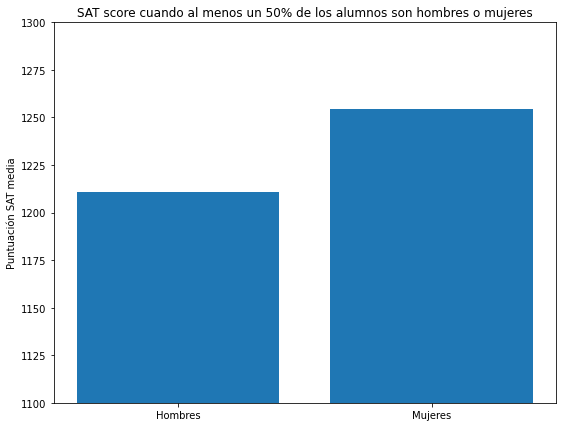

In [124]:
# Resultados (más del 50%)
plt.figure(figsize=(9,7))
plt.bar(['Hombres', 'Mujeres'],[male_more_50_mean, female_more_50_mean])
plt.title('SAT score cuando al menos un 50% de los alumnos son hombres o mujeres')
plt.ylabel('Puntuación SAT media')
plt.ylim(1100, 1300)
plt.show()

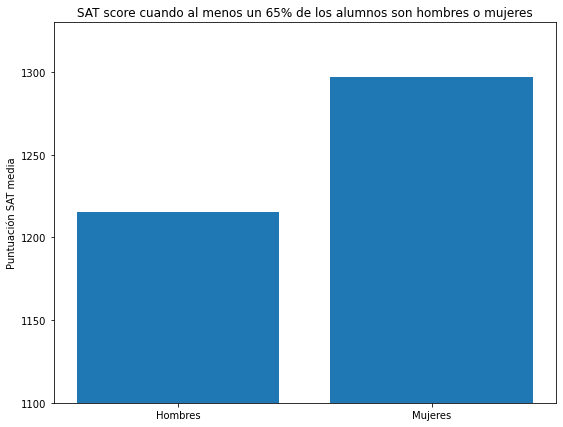

In [125]:
# Resultados (más del 65%)
plt.figure(figsize=(9,7))
plt.bar(['Hombres', 'Mujeres'],[male_more_65_mean, female_more_65_mean])
plt.title('SAT score cuando al menos un 65% de los alumnos son hombres o mujeres')
plt.ylabel('Puntuación SAT media')
plt.ylim(1100, 1330)
plt.show()

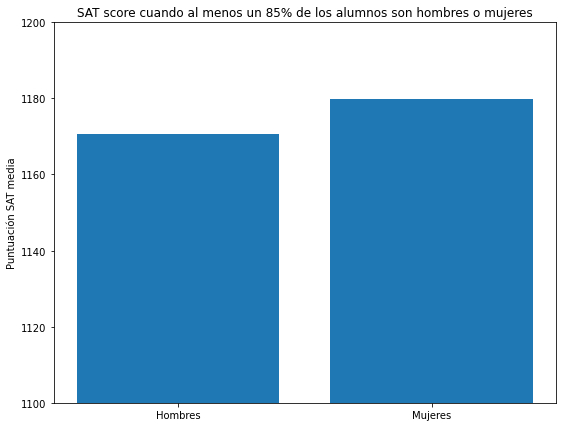

In [126]:
# Resultados (más del 85%)
plt.figure(figsize=(9,7))
plt.bar(['Hombres', 'Mujeres'],[male_more_85_mean, female_more_85_mean])
plt.title('SAT score cuando al menos un 85% de los alumnos son hombres o mujeres')
plt.ylabel('Puntuación SAT media')
plt.ylim(1100, 1200)
plt.show()

### Correlación entre exámenes AP y SAT

En EEUU, los estudiantes realizan exámenes AP para conseguir créditos de universidades. Hay exámenes AP (Advanced Placement) de diversos tipos.

Tiene sentido que el número de estudiantes que opten por realizar exámenes AP estén fuertemente correlacionados con las puntuaciones SAT. Vamos a explorar esta relación.

Vamos a ver el porcentaje de estudiantes que optaron por realizar exámenes AP por cada escuela.

In [127]:
# Por defecto, la columna trae un espacio al final. Renombramos
combined['AP Test Takers'] = combined['AP Test Takers '] 

In [128]:
# Convertimos de tipo string a numérico
combined['AP Test Takers'] = pd.to_numeric(combined['AP Test Takers'], errors='coerce')

In [129]:
# Como ahora contiene valores nulos, rellenamos dichos valores con ceros, para poder operar
combined['AP Test Takers'] = combined['AP Test Takers'].fillna(0)

In [130]:
# Dividimos las columnas
ap_per = combined['AP Test Takers'] / combined['total_enrollment']

In [131]:
# Agregamos la columna al DataFrame
combined['ap_per'] = ap_per

Ahora que tenemos el porcentaje de alumnos por cada escuela que optaron por realizar el examen AP, vamos a ver la correlación entre dicho porcentaje y las puntuaciones SAT:

In [132]:
# Correlación entre el porcentaje de alumnos que realizaron examen AP y puntuaciones SAT
combined['ap_per'].corr(combined['sat_score'])

0.6248782038580442

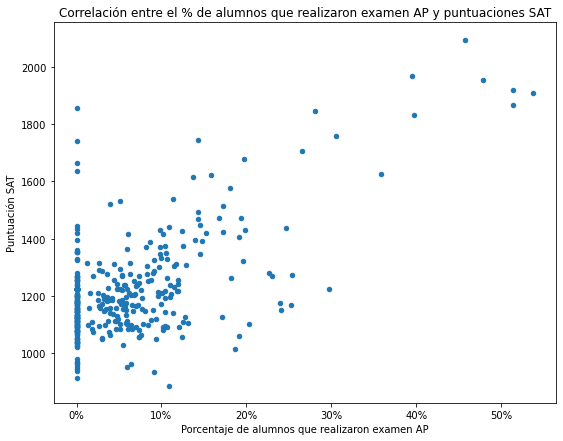

In [133]:
# Graficamos los resultados
combined.plot.scatter(figsize=(9,7),y='sat_score', x='ap_per', title='Correlación entre el % de alumnos que realizaron examen AP y puntuaciones SAT')
plt.xlabel('Porcentaje de alumnos que realizaron examen AP')
plt.xticks(ticks=[0,.1,.2,.3,.4,.5], 
           labels=['0%','10%','20%','30%','40%','50%'])
plt.ylabel('Puntuación SAT')
plt.show()

Vemos que según aumenta el número de alumnos que realizaron exámenes AP, las puntuaciones SAT aumentan.

Cuando el porcentaje de alumnos que realizaron examen AP supera el 30%, las puntuaciones SAT medias están siempre por encima de 1600 puntos.